In [64]:
# Import Packages

#Data Structure/Organization Packages
import pandas as pd
import xarray as xr
import numpy as np
import numpy.ma as ma

# Plotting Packages
import matplotlib.pyplot as plt
from cmocean import cm as cmo
import seaborn as sns
import matplotlib.patches as patch
from labellines import labelLine, labelLines
import matplotlib.colors as mpcolors
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patheffects as pe 

# Utility Packages
import random as rand
import os
import math
# import dataframe_image as dfi
import itertools
from scipy import interpolate
from tqdm import tqdm

# Oceanography Packages
import gsw
import importlib
import geopy.distance

# Import Packages

#Data Structure/Organization Packages
import pandas as pd
import xarray as xr
import numpy as np
import numpy.ma as ma



In [65]:
import matplotlib as mpl

In [66]:
# Modules
import mod_main as sg
import mod_L3proc as gproc     # for L3 grid processing
import mod_DFproc as dfproc    # for dataframe processing
import mod_plot as sgplot  
import mod_RFR as rfr
import mod_MLV as mlv

# from mod_plot import my_params
from mod_plot import *
from importlib import reload

plt.rcParams.update(my_params(16))

In [67]:
from mod_main import df_659, df_660, dav_659, dav_660
from mod_main import sgfloat, dav_6030, dav_float
from mod_RFR import RF_validation, RF_test, RF_modelmetrics, RF_featimps
from mod_RFR import RF_kfold, RF_loo

from mod_MLV import mlstat_659, mlstat_660, mlstat_float
from mod_MLV import hvariance_659, hvariance_660
from mod_main import floatDF
wmoids = floatDF.wmoid.unique()


# DATA: STUDY REGION FINAL

<AxesSubplot: >

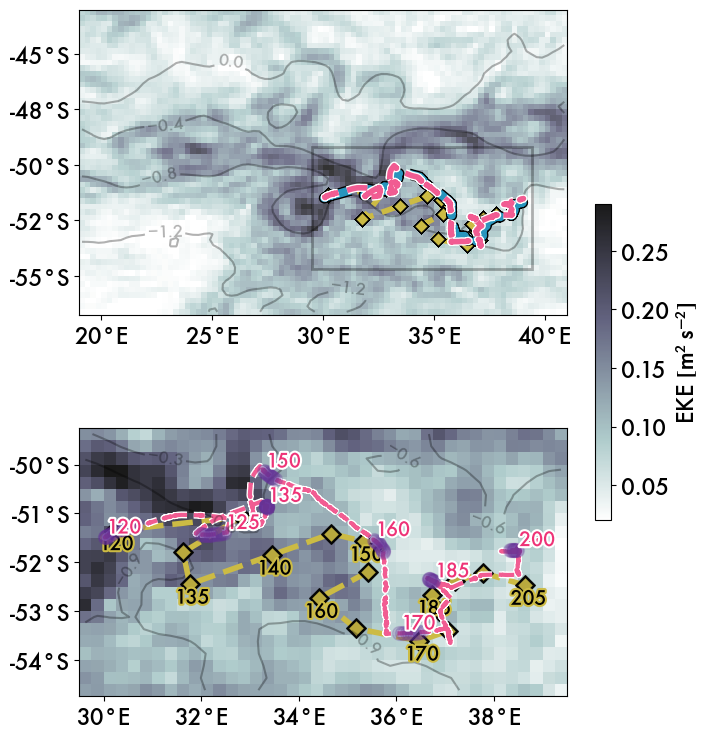

In [1459]:
reload(sgplot)
sgplot.study_region_adt()

/opt/homebrew/Caskroom/mambaforge/base/envs/mlsogos/lib/python3.8/site-packages/labellines/core.py:204: UserWarning: The value at position 0 in `xvals` is outside the range of its associated line (xmin=28.246, xmax=33.568, xval=27.35). Clipping it into the allowed range.
  warnings.warn(
/opt/homebrew/Caskroom/mambaforge/base/envs/mlsogos/lib/python3.8/site-packages/labellines/core.py:204: UserWarning: The value at position 5 in `xvals` is outside the range of its associated line (xmin=56.495, xmax=64.896, xval=50.3). Clipping it into the allowed range.
  warnings.warn(


Text(0.5, 1.0, 'BGC-Argo Floats for Training')

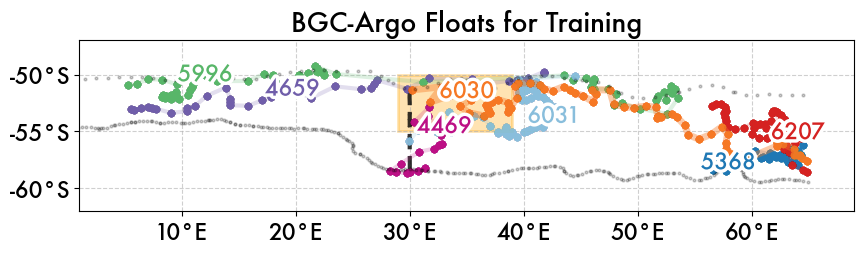

In [1475]:
reload(sgplot)
ax = sgplot.training_float_map(floatDF, fsize=(10,8))
ax.set_title('BGC-Argo Floats for Training')

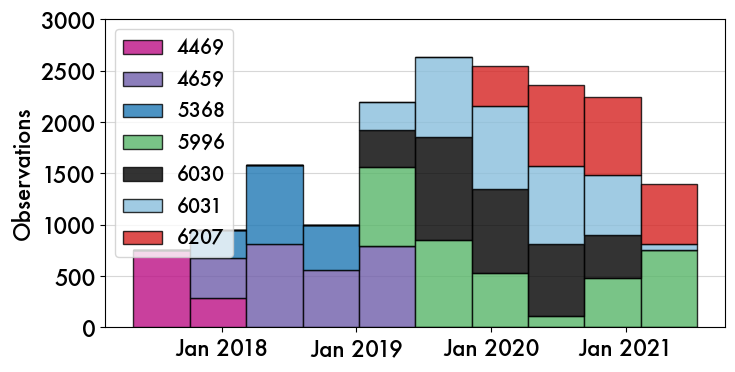

In [1479]:
reload(sgplot)
sgplot.argo_time_coverage(floatDF, fsize=(8,4), fontsize=12)

# RF TRAINING

# RF: VALIDATION

In [12]:
rerun = True
desc='full'
if rerun:
    model_list = ['Model_A', 'Model_B', 'Model_C', 'Model_D', 'Model_E', 'Model_F', 'Model_G']

    # Initialize object again
    cv_kfold = rfr.CrossVal_KFold(model_list)

    for mdl in model_list: 
        df = pd.read_csv('../working-vars/RF-crossval/kfold_valDF_' + mdl + '_' + desc + '.csv')
        crossfold_MAEs = pd.read_csv('../working-vars/RF-crossval/kfold_list_MAEs_' + desc + '.csv')

        # Here's where we use the imported data 
        cv_kfold.val_DF[mdl] = df.copy()

        # Later, we will use the cv_kfold.val_error['Mdl_G'] to plot the histogram of full errors
        cv_kfold.val_error[mdl] = cv_kfold.val_DF[mdl]['val_error'] #allfold_val_df['val_error'] 
        cv_kfold.val_relative_error[mdl] = cv_kfold.val_DF[mdl]['val_relative_error']

        # We use the next imported data, MAE lists across models, 
        cv_kfold.MAEs[mdl] = crossfold_MAEs[mdl] # this is a list of 10 MAEs
                                                # mean of this is the final validation error for Model_X
        cv_kfold.IQRs[mdl] = crossfold_MAEs[mdl]


In [59]:
RF_validation['Model_G'].val_error.median()

-0.0171206363627192

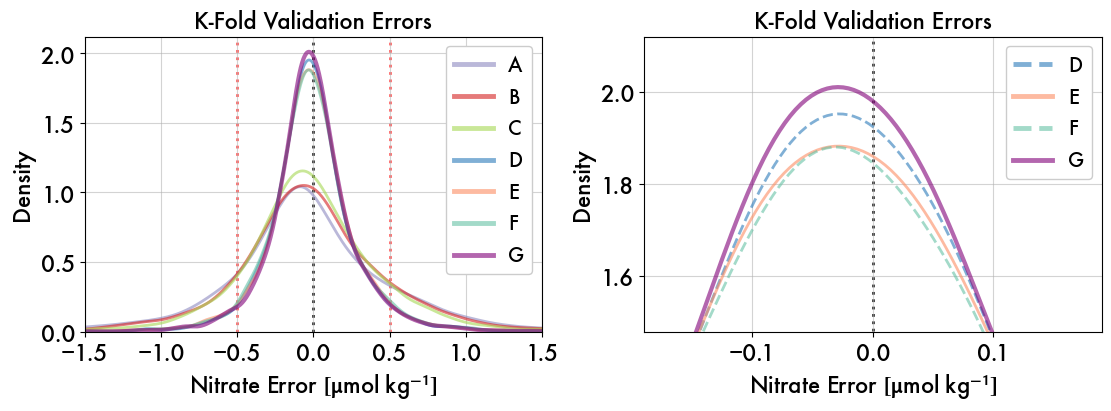

In [13]:
# New KDE plot using all validation errors from K-Fold 
tag = 'Predicted - Observed Nitrate'
var = 'val_error'; ymax=2.12
data = cv_kfold.val_error
# ymax = 2.1


# Make Figure with 2 Subplots
fig, axs = plt.subplots(1, 2, figsize=(11,4), layout='constrained')
axs=axs.flatten()

for ax in axs[0:1]:
    for mod in model_list[:]: 
        RF = data[mod].values

        # Add Gaussian KDE to estimate probability density function
        x = np.linspace(RF.min(), RF.max(), 1000)
        kde = scipy.stats.gaussian_kde(RF)

        lw = 2; ls = 'solid'
        if mod == 'Model_G':
            lw=lw+1
        ax.plot(x, kde(x), color=model_palettes[mod], linewidth=lw, linestyle=ls, label=mod[-1], alpha=0.6)

    if var == 'val_error':
        ax.set_xlim([-1.5, 1.5])
        ax.set_ylim([0, ymax])

    leg = ax.legend(fontsize=14, framealpha=1)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3.5)
    

for ax in axs[1:]:
    for mod in model_list[3:]: # ['Model_A', 'Model_G']: #
        RF = data[mod].values

        # Gaussian KDE
        x = np.linspace(RF.min(), RF.max(), 1000)
        kde = scipy.stats.gaussian_kde(RF)

        lw = 2; ls = 'solid'
        if mod == 'Model_G':
            lw=lw+1
        if mod in ['Model_D', 'Model_F']:
            ls = '--'
        plt.plot(x, kde(x), color=model_palettes[mod], linewidth=lw, linestyle = ls, label=mod[-1], alpha=0.6)

    ax.set_xlim([-.19, .19])
    ax.set_ylim([1.48, ymax])

    # Legend
    leg = plt.legend(fontsize=14, framealpha=1)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3.5)

umol_unit = (r'$\mathbf{[\mu} \mathregular{mol~kg} \mathbf{^{-1}]}$')


for ax in axs:
    # Show float uncertainty and 0 line
    ax.axvline(x=0.5, color='r', linestyle='dotted', linewidth=2, alpha=0.6, zorder=0)
    ax.axvline(x=-0.5, color='r', linestyle='dotted', linewidth=2, alpha=0.6, zorder=0)
    ax.vlines(0, ymin=0, ymax=3, colors='k', alpha=0.8, linewidth=2, linestyle='dotted', zorder=1)
    # ax.set_ylim([0,ymax])
    ax.grid(alpha=0.55, zorder=1)

    ax.set_ylabel('Density')
    ax.set_xlabel("Nitrate Error " + umol_unit)
    ax.set_title('K-Fold Validation Errors', fontsize=16)


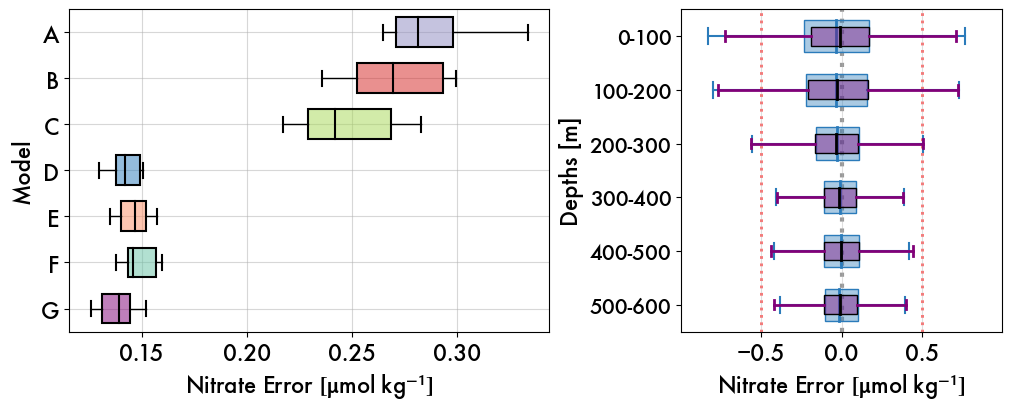

In [40]:
# Plot boxplots for 10 MAEs per model
pressure_ranges = [(0, 100), (100, 200), (200, 300), (300, 400), (400, 500),
                    (500, 600) ] #(600, 700), (700, 800), (800, 900), (900, 1000)]
mod_one = 'Model_D'
mod_two = 'Model_G'
bias_one = rfr.get_depth_bias(cv_kfold.val_DF[mod_one], pressure_ranges)
bias_two = rfr.get_depth_bias(cv_kfold.val_DF[mod_two], pressure_ranges)



# Make Figure with 2 Subplots
fig, axs = plt.subplots(1, 2, figsize=(10,4), layout='constrained', width_ratios=[1.5,1])
axs=axs.flatten()


for ax in axs[:1]:
    data = cv_kfold.MAEs  
    lw= 1.5
    bplot = ax.boxplot(data.values(), widths=0.65, vert=False, patch_artist=True,
                    medianprops = {'color':'k', 'linewidth':lw},
                    capprops= {'color':'k', 'linewidth':lw},
                    flierprops= {'color':'k', 'linewidth':lw},
                    boxprops = {'color':'k', 'linewidth':lw})
    ax.set_yticklabels([x[-1] for x in data.keys()])
    ax.grid(zorder=1, alpha=0.5)
    ax.invert_yaxis()
    ax.set_ylabel('Model', fontsize=16)
    ax.set_xlabel("Nitrate Error " + umol_unit)

    colors = []
    for mdl in model_list:
        colors.append(model_palettes[mdl])

    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(mpl.colors.to_rgba(color, alpha=0.5))
    # ax.axvline(x=0.5, color='r', linestyle='dotted', linewidth=2, alpha=0.6, zorder=0)

for ax in axs[1:]:
    color_one = model_palettes['Model_D'] # sns.color_palette("Purples")[3]
    color_two = model_palettes['Model_G']


    bplot_one = ax.boxplot(bias_one.values(), vert=False, showfliers=False, widths=0.6, 
                        patch_artist=True, 
                        medianprops= {'color':color_one, 'linewidth':2},
                        capprops={'color':color_one, 'linewidth':1.5},
                        whiskerprops={'color':color_one, 'linewidth':1.5},
                        flierprops={'color':color_one, 'linewidth':1.5},
                        boxprops = {'color':color_one, 'linewidth':1},
                        zorder=2)
    for patch, color in zip(bplot_one['boxes'], [color_one]*10):
        patch.set_facecolor(mpl.colors.to_rgba(color, alpha=0.4))


    bplot_two = ax.boxplot(bias_two.values(), vert=False, showfliers=False, widths=0.35, 
                        patch_artist=True, 
                        medianprops= {'color':'k', 'linewidth':2},
                        capprops={'color':color_two, 'linewidth':2},
                        whiskerprops={'color':color_two, 'linewidth':2},
                        flierprops={'color':color_two, 'linewidth':2},
                        boxprops = {'color':'k', 'linewidth':1},
                        zorder=3)
    for patch, color in zip(bplot_two['boxes'], [color_two]*10):
        patch.set_facecolor(mpl.colors.to_rgba(color, alpha=0.4))

    ax.invert_yaxis()
    ax.axvline(x=0, color='k', linestyle='dotted', linewidth=3, alpha=0.4, zorder=0)
    

    labels = bias_one.keys()
    ax.set_yticks(range(1, len(labels) + 1), labels, fontsize=15)
    ax.set_ylabel("Depths [m]", fontsize=16)
    ax.set_xlabel("Nitrate Error " + umol_unit, fontsize=16)
    ax.set_xlim([-.99, .99])

    # ax.set_title("Cross-Validation Errors", fontsize=16)

    # ax.legend([bplot_one["boxes"][0], bplot_two["boxes"][0]], [mod_one[-1], mod_two[-1]], loc='lower right', fontsize=15)
    ax.grid(axis='x', zorder=1, alpha=0.4)

    ax.axvline(x=0.5, color='r', linestyle='dotted', linewidth=2, alpha=0.6, zorder=0)
    ax.axvline(x=-0.5, color='r', linestyle='dotted', linewidth=2, alpha=0.6, zorder=0)


In [49]:
RF_loo_WMO.at['5904469','Model_D']

KeyError: '5904469'

In [51]:
RF_loo_WMO.at[1,'Model_D']

0.41295

In [50]:
wmos

[5904469, 5904659, 5905368, 5905996, 5906031, 5906207]

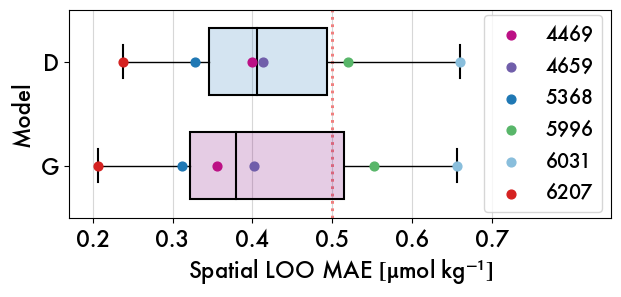

In [54]:
from mod_RFR import RF_loo # this is like cvloo, holding MAEs by model
from mod_RFR import RF_loo_WMO # this is like cvloo_metrics, by WMO for colored dots

# Plot boxplots for 6 different LOO's
wmos = [x for x in wmoids if x != 5906030] 
data = {k: RF_loo[k] for k in ('Model_D', 'Model_G')}
fig, ax = plt.subplots(figsize=(7,2.7))

lw= 1.5
bplot = ax.boxplot(data.values(), widths=0.65, vert=False, patch_artist=True,
                   medianprops = {'color':'k', 'linewidth':lw},
                   capprops= {'color':'k', 'linewidth':lw},
                   flierprops= {'color':'k', 'linewidth':lw},
                   boxprops = {'color':'k', 'linewidth':lw})
ax.set_yticklabels([x[-1] for x in data.keys()])

ax.grid(axis='x', zorder=1, alpha=0.5)
ax.set_ylabel('Model')
ax.set_xlabel('Spatial LOO MAE ' + umol_unit)
ax.set_xticks([.2, .3, .4, .5, .6, .7])


colors = [model_palettes['Model_D'], model_palettes['Model_G']]
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(mpcolors.to_rgba(color, alpha=0.2))

for ind, wmo in enumerate(wmos): 
        ax.scatter(RF_loo_WMO.at[ind,'Model_D'],1, color=wmo_colors[wmo], s = 40, label= str(wmo)[-4:], zorder=3)
        ax.scatter(RF_loo_WMO.at[ind,'Model_G'],2, color=wmo_colors[wmo], s=40, zorder=3)

ax.legend(loc='center right', fontsize=14)
ax.set_xlim([.17, .85])
ax.axvline(x=0.5, color='r', linestyle='dotted', linewidth=2, alpha=0.6, zorder=0)
ax.invert_yaxis()

# RF TEST: ERROR SECTIONS + NN COMPARISON

In [60]:
RF_test['Model_G'].test_error

0       0.044274
1       0.061831
2       0.038521
3       0.144736
4       0.205086
          ...   
3303    0.163157
3304   -0.031022
3305    0.059444
3306    0.015344
3307    0.116578
Name: test_error, Length: 3308, dtype: float64

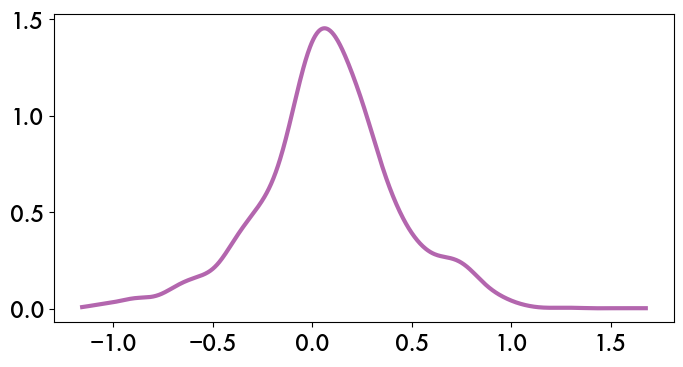

In [61]:
dat = RF_test['Model_G'].test_error

fig = plt.figure(figsize=(8,4))
ax = fig.gca()

x = np.linspace(dat.min(), dat.max(), 1000)
kde = scipy.stats.gaussian_kde(dat)

lw = 2; ls = 'solid'
if mod == 'Model_G':
    lw=lw+1
ax.plot(x, kde(x), color=model_palettes[mod], linewidth=lw, linestyle=ls, label=mod[-1], alpha=0.6)

# if var == 'val_error':
#     ax.set_xlim([-1.5, 1.5])
#     ax.set_ylim([0, ymax])

# leg = ax.legend(fontsize=14, framealpha=1)
# for legobj in leg.legendHandles:
#     legobj.set_linewidth(3.5)



In [15]:
# Load datasets to compare
sogos_float = RF_test['Model_G']

# After running CANYON and ESPER, make DataFrames
dir = '../working-vars/'
sogos_canyon = pd.read_csv(dir + 'CANYON-prediction/wmo5906030_MATLAB_canyon_pred_nov2023.csv')
sogos_esper = pd.read_csv(dir + '/ESPER-prediction/wmo5906030_MATLAB_esper_pred_nov2023.csv')

for var in ['pressure', 'yearday', 'nitrate']:
    sogos_canyon[var] = np.array(sogos_float[var])
    sogos_esper[var] = np.array(sogos_float[var])

sogos_canyon['prediction_error'] = sogos_canyon.prediction - sogos_canyon.nitrate
sogos_canyon['pred_relative_error'] = sogos_canyon.prediction_error/sogos_canyon.nitrate

sogos_esper['prediction_error'] = sogos_esper.prediction - sogos_esper.nitrate
sogos_esper['pred_relative_error'] = sogos_esper.prediction_error/sogos_esper.nitrate

[Text(181, 0, "Jul '19"),
 Text(273, 0, "Oct '19"),
 Text(365, 0, "Jan '20"),
 Text(456, 0, "Apr '20"),
 Text(548, 0, "Jul '20"),
 Text(639, 0, "Oct '20")]

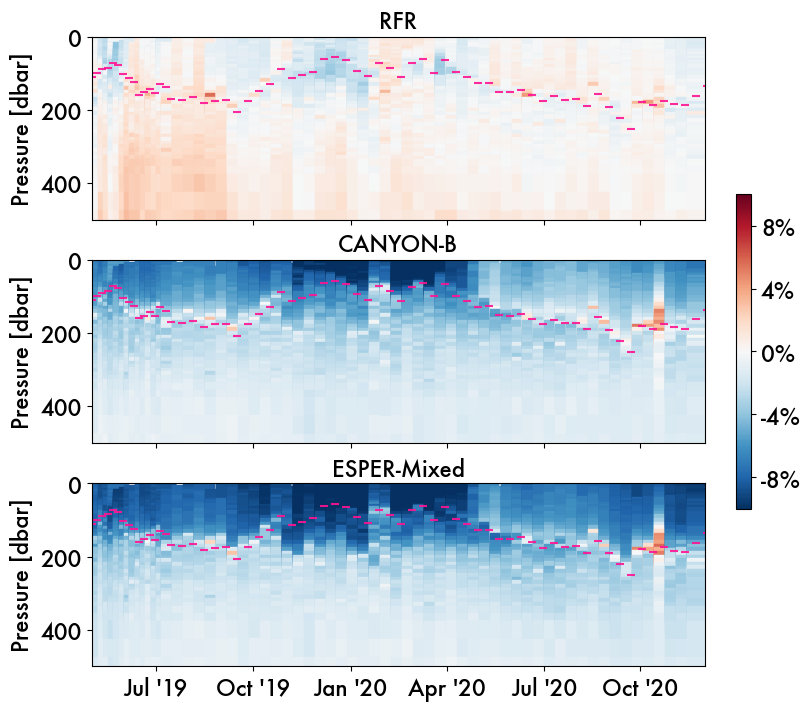

In [16]:
# *PAPER FIG: RELATIVE 
# (Absolute, 3 subplots) Prediction, Obs, and Error Profiles

dat = RF_test['Model_G']

fig, axs = plt.subplots(3,1, figsize=(8,7), layout='constrained', sharex=True)
axs = axs.flatten()

sca0 = axs[0].scatter(dat.yearday, dat.pressure, c=dat.test_relative_error, cmap='RdBu_r', s=200, marker='s', vmin=-.10, vmax=.10) #, vmin=0, vmax=0.005
axs[0].set_title('RFR', fontsize=16)

sca2 = axs[1].scatter(sogos_canyon.yearday, sogos_canyon.pressure, c=sogos_canyon.pred_relative_error, cmap='RdBu_r', s=200, marker='s', vmin=-.10, vmax=.10)
axs[1].set_title('CANYON-B', fontsize=16)

sca1 = axs[2].scatter(sogos_esper.yearday, sogos_esper.pressure, c=sogos_esper.pred_relative_error, cmap='RdBu_r', s=200, marker='s',vmin=-.10, vmax=.10) #, vmin=0, vmax=0.005
axs[2].set_title('ESPER-Mixed', fontsize=16) 


ticklist = [-0.08, -0.04, 0, 0.04, 0.08] 
cbar = fig.colorbar(sca1, ax=axs[:], ticks=ticklist, shrink=0.5).ax.set_yticklabels(['-8%', '-4%', '0%', '4%', '8%'], fontsize=16) 
# cbar.ax.set_yticklabels(['-8%', '-4%', '0%', '4%', '8%']) 

for ax in axs:
    ax.invert_yaxis()

    ax.set_xlim([120,700])
    ax.set_ylim([500,0])
    ax.scatter(dav_6030.yearday, dav_6030.mld, c='deeppink', s=40, marker='_', alpha=0.9, label='MLD')
    ax.set_ylabel('Pressure [dbar]')
# axs[2].set_xlabel('Days since Jan 01 2019')

# axs[0]
xt = [181, 273, 365, 456, 548, 639]
axs[2].set_xticks(xt)
axs[2].set_xticklabels(['Jul \'19', 'Oct \'19','Jan \'20', 'Apr \'20', 'Jul \'20', 'Oct \'20'])

# axs[2].set_xticklabels(str(sg.ytd2datetime(k))[-5:] for k in xt)
# axs[2].set_xlabel('[Yearday]')

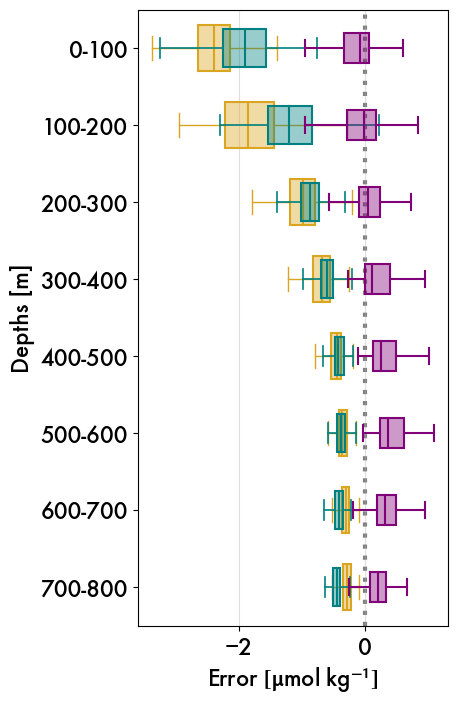

In [17]:
# Plot bias by depths, for CANYON/ESPER 
mod_one = 'RFR'
mod_two = 'CANYON-B'
mod_three = 'ESPER-Mixed'

pressure_ranges = [(0, 100), (100, 200), (200, 300), (300, 400), 
                   (400, 500), (500, 600), (600, 700), (700, 800)]

bias_float = rfr.get_depth_bias(sogos_float, pressure_ranges, var='test_error')
bias_canyon = rfr.get_depth_bias(sogos_canyon, pressure_ranges, var='prediction_error')
bias_esper = rfr.get_depth_bias(sogos_esper, pressure_ranges, var='prediction_error')

color_one = model_palettes['Model_G'] # sns.color_palette("Purples")[3]
color_two =  'teal' #model_palettes['Model_D']
color_three = 'goldenrod'# model_palettes['Model_E']


# col_one = {'color':color_one, 'linewidth':1}
col_one = {'color':color_one, 'linewidth':1}
col_two = {'color':color_two, 'linewidth':1}
col_three = {'color':color_three, 'linewidth':1}

fig = plt.figure(figsize=(4,8))
# fig = plt.figure(figsize=(13,13))
ax = fig.gca()

# ESPER 
lw = 1
bplot_three = ax.boxplot(bias_esper.values(), vert=False, showfliers=False, widths=0.6, 
                    patch_artist=True, 
                    medianprops= {'color':color_three, 'linewidth':1.5},
                    capprops={'color':color_three, 'linewidth':lw},
                    whiskerprops={'color':color_three, 'linewidth':lw},
                    flierprops={'color':color_three, 'linewidth':lw},
                    boxprops = {'color':color_three, 'linewidth':1.5},
                    zorder=3)
for patch, color in zip(bplot_three['boxes'], [color_three]*10):
    patch.set_facecolor(mpcolors.to_rgba(color, alpha=0.4))

# CANYON
lw = 1.2
bplot_two = ax.boxplot(bias_canyon.values(), vert=False, showfliers=False, widths=0.5, 
                    patch_artist=True, 
                    medianprops= {'color':color_two, 'linewidth':1.5},
                    capprops={'color':color_two, 'linewidth':lw },
                    whiskerprops={'color':color_two, 'linewidth':lw },
                    flierprops={'color':color_two, 'linewidth':lw},
                    boxprops = {'color':color_two, 'linewidth':1.5},
                    zorder=4)
for patch, color in zip(bplot_two['boxes'], [color_two]*10):
    patch.set_facecolor(mpcolors.to_rgba(color, alpha=0.4))

# RFR
lw = 1.5
bplot_one = ax.boxplot(bias_float.values(), vert=False, showfliers=False, widths=0.4, 
                    patch_artist=True, 
                    medianprops= {'color':color_one, 'linewidth':lw},
                    capprops={'color':color_one, 'linewidth':lw },
                    whiskerprops={'color':color_one, 'linewidth':lw },
                    flierprops={'color':color_one, 'linewidth':lw },
                    boxprops = {'color':color_one, 'linewidth':1.5},
                    zorder=5)
for patch, color in zip(bplot_one['boxes'], [color_one]*10):
    patch.set_facecolor(mpcolors.to_rgba(color, alpha=0.4))

ax.invert_yaxis()
ax.axvline(x=0, color='k', linestyle='dotted', linewidth=3, alpha=0.5, zorder=0)

labels = bias_float.keys()
plt.yticks(range(1, len(labels) + 1), labels)
plt.ylabel("Depths [m]")
plt.xlabel("Error " + umol_unit)
# plt.title("Test Errors", fontsize=16)

# ax.legend([bplot_one["boxes"][0], bplot_two["boxes"][0], bplot_three["boxes"][0]], 
#           [mod_one, mod_two, mod_three], loc='lower left', fontsize=15)
ax.grid(axis='x', zorder=1, alpha=0.4)
# plt.savefig('../figures/canyon_esper_comparison_bydepth.png', dpi=300, bbox_inches='tight')

# MLV: GLIDER SECTIONS

### Resolution Comparison Float vs Glider

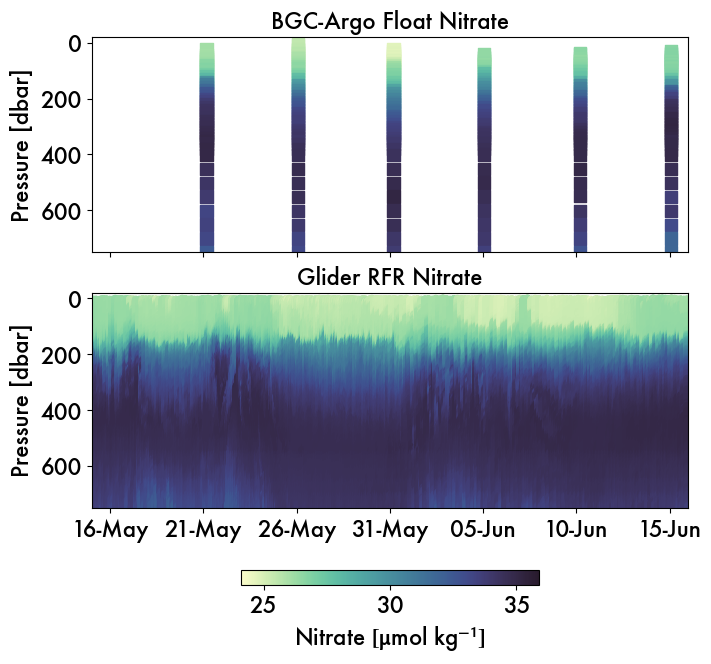

In [1444]:
importlib.reload(sgplot)
# sgplot.compare_resolution(df_660, fsize=(9,6), minday=129, maxday=161, maxpres=750, dateformat=False)

sgplot.compare_resolution(df_660, fsize=(7,6.5), minday=129, maxday=161, maxpres=750, dateformat=True, vertical=False)

In [80]:
np.arange(130, 166, 5)

array([130, 135, 140, 145, 150, 155, 160, 165])

### Glider Sections

In [1354]:
df_glid

Unnamed: 0                           juld     yearday      lat  \
0             4032  2019-04-30 12:14:50.707000064  119.510309 -51.4954   
1             5040  2019-04-30 12:14:55.707000064  119.510367 -51.4953   
2             6048  2019-04-30 12:15:00.707000064  119.510425 -51.4953   
3             7056  2019-04-30 12:15:08.206500096  119.510512 -51.4953   
4             8064  2019-04-30 12:15:15.707000064  119.510598 -51.4952   
...            ...                            ...         ...      ...   
417601      219189  2019-05-30 23:59:33.206000128  149.999690 -50.2111   
417602      220197  2019-05-30 23:59:40.706000128  149.999777 -50.2111   
417603      221205  2019-05-30 23:59:45.707000064  149.999835 -50.2111   
417604      222213  2019-05-30 23:59:50.706000128  149.999892 -50.2111   
417605      223221  2019-05-30 23:59:55.706000128  149.999950 -50.2111   

            lon  pressure        CT         SA      oxygen  buoyancy  ...  \
0       30.0251     4.035  3.653773  33.960220  326.859426 -0.000001  ...   
1       30.0251     5.044  3.649773  33.961220  327.084300 -0.000001  ...   
2       30.0252     6.053  3.650773  33.960220  327.267310 -0.000012  ...   
3       30.0252     7.062  3.648773  33.958220  327.392493 -0.000008  ...   
4       30.0253     8.070  3.646773  33.958220  327.518402  0.000024  ...   
...         ...       ...       ...        ...         ...       ...  ...   
417601  33.3752   218.996  1.958773  34.330220  252.337601  0.000029  ...   
417602  33.3752   220.006  1.966773  34.332222  252.458764  0.000004  ...   
417603  33.3752   221.016  1.964773  34.332222  251.894907  0.000005  ...   
417604  33.3752   222.026  1.961773  34.333220  251.652559  0.000014  ...   
417605  33.3752   223.035  1.959773  34.335220  251.718164  0.000017  ...   

         profid  dive     sigma0     spice        AOU       o2sat  \
0       6600000     1  27.013210 -0.409161  -6.502479  320.356948   
1       6600000     1  27.014391 -0.408886  -6.698717  320.385583   
2       6600000     1  27.013503 -0.409485  -6.887058  320.380252   
3       6600000     1  27.012116 -0.411114  -6.991729  320.400764   
4       6600000     1  27.012310 -0.411330  -7.102091  320.416311   
...         ...   ...        ...       ...        ...         ...   
417601  6600456   231  27.455573 -0.313788  80.754921  333.092521   
417602  6600456   231  27.456547 -0.311687  80.561706  333.020470   
417603  6600456   231  27.456703 -0.311861  81.142295  333.037202   
417604  6600456   231  27.457732 -0.311420  81.407132  333.059692   
417605  6600456   231  27.459480 -0.310191  81.353064  333.071227   

        log_buoyancy     ydcos     ydsin  nitrate_G  
0                NaN -0.467516  0.883985  24.052903  
1                NaN -0.467517  0.883984  24.073713  
2                NaN -0.467518  0.883984  24.056331  
3                NaN -0.467519  0.883983  23.871766  
4         -10.656217 -0.467521  0.883982  23.880342  
...              ...       ...       ...        ...  
417601    -10.446916 -0.847538  0.530735  32.456598  
417602    -12.512258 -0.847539  0.530733  32.471494  
417603    -12.236722 -0.847539  0.530732  32.479042  
417604    -11.154992 -0.847540  0.530732  32.483374  
417605    -10.997112 -0.847540  0.530731  32.482757  

[391185 rows x 24 columns]

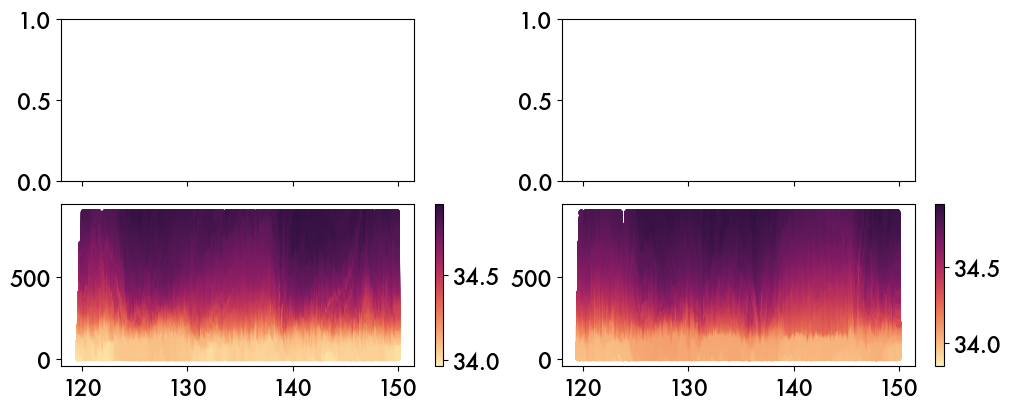

In [1356]:
fig, axs = plt.subplots(2,2, figsize=(10,4), sharex=True, layout='constrained')


for ind, df_glid in enumerate([df_659, df_660]):
    df_glid = df_glid[df_glid.pressure<900]
    df_glid = df_glid[df_glid.yearday<150]
    sca = axs[1,ind].scatter(df_glid.yearday, df_glid.pressure,c=df_glid.SA, 
        cmap=cmo.matter, s=dotsize, zorder=3)

    plt.colorbar(sca, ax=axs[1,ind])

# for ax in axs.flatten():
#     ax.invert_yaxis()



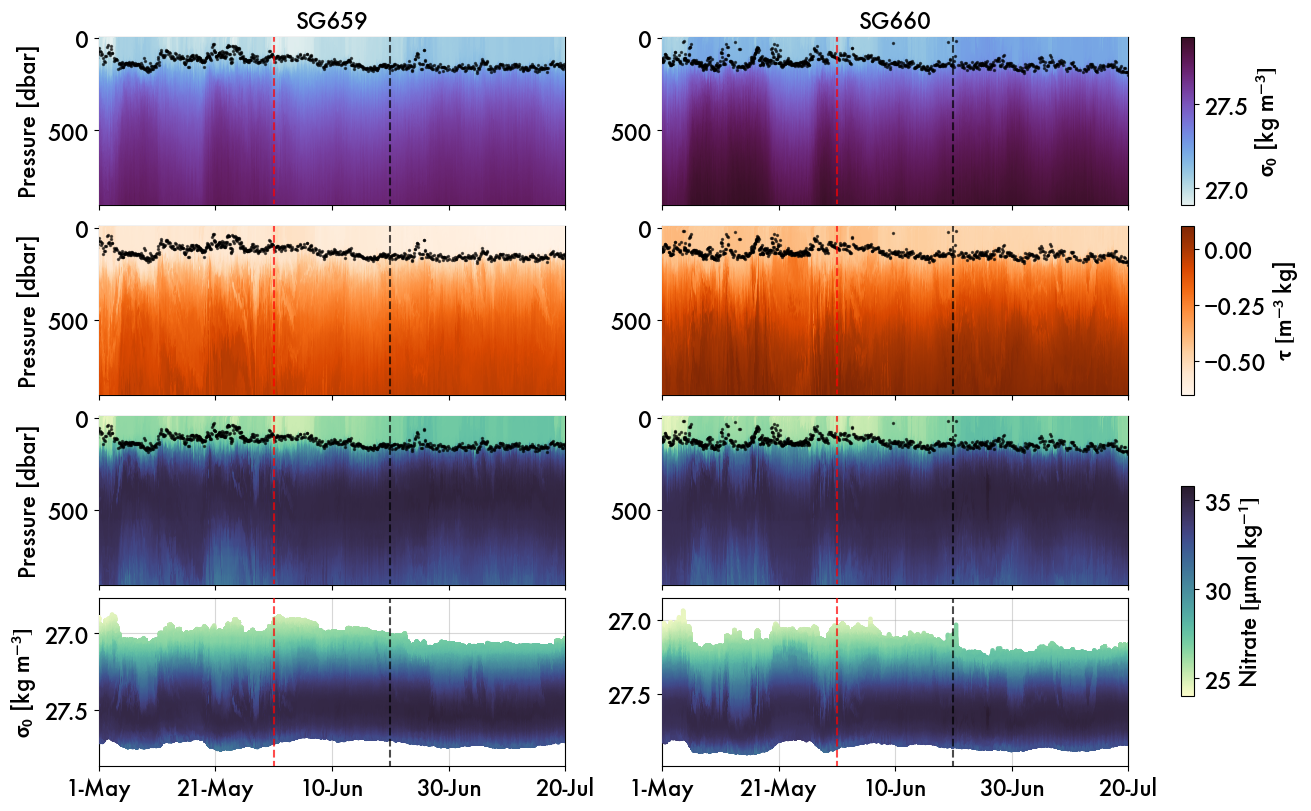

(<Figure size 1300x800 with 11 Axes>,
 array([[<AxesSubplot: title={'center': 'SG659'}, ylabel='Pressure [dbar]'>,
         <AxesSubplot: title={'center': 'SG660'}>],
        [<AxesSubplot: ylabel='Pressure [dbar]'>, <AxesSubplot: >],
        [<AxesSubplot: ylabel='Pressure [dbar]'>, <AxesSubplot: >],
        [<AxesSubplot: ylabel='$\\mathbf{\\sigma_0}$ [kg$\\mathbf{~m^{-3}]}$'>,
         <AxesSubplot: >]], dtype=object))

In [1359]:
reload(sgplot)
sgplot.plt_glider_sections(preslim=900, fsize=(13,8), font = 16, dateformat=True)

# MLV: TIME SERIES

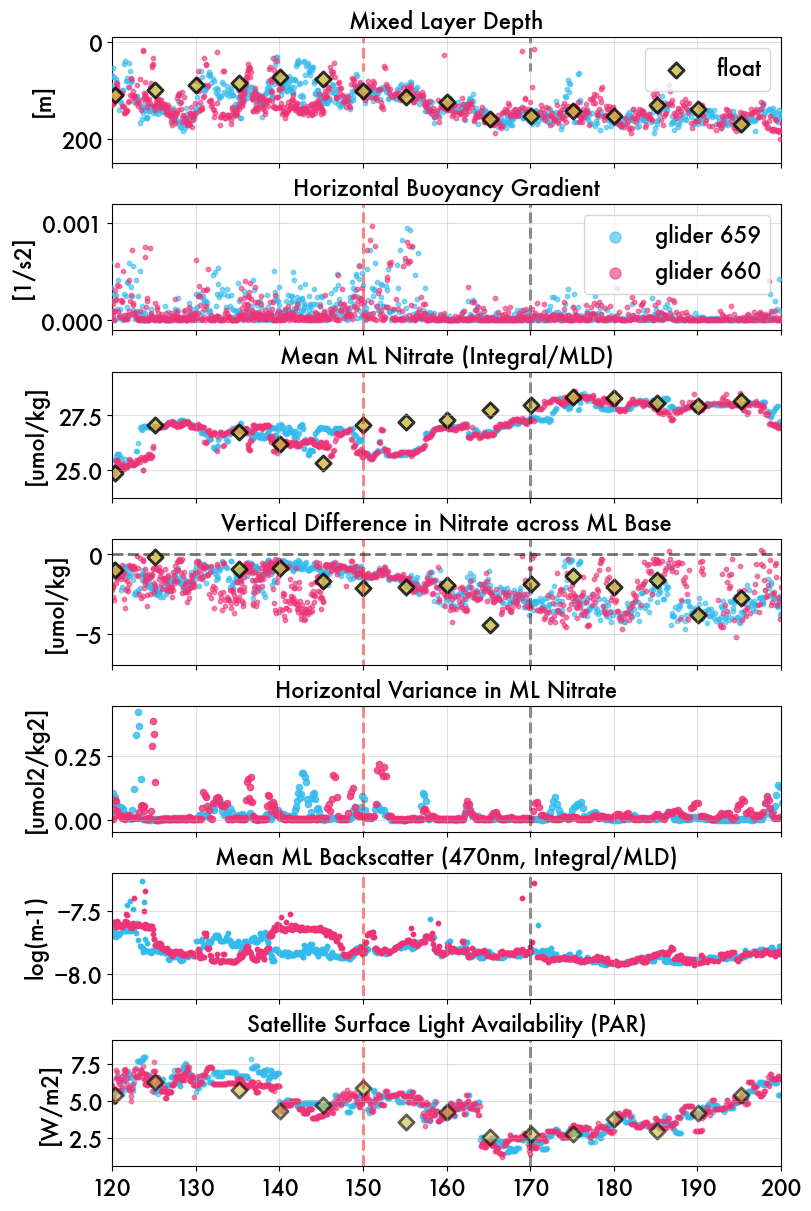

In [27]:
#  LARGE FOR POSTER
# Compare ML depth, variable mean, and variable variance
# BOTH  GLIDER

# from mod_plot import plat_colors

fig, axs = plt.subplots(7,1,figsize=(8,12), sharex=True, layout='constrained') # 14,12
axs = axs.flatten()
dotsize = 10
diasize = 60
titlesize=16

for ax in axs[0:1]:
    ax.scatter(mlstat_659.yearday, mlstat_659.mld, s=dotsize, alpha=0.6, color=plat_colors['sg659'], zorder=3)
    ax.scatter(mlstat_660.yearday, mlstat_660.mld, s=dotsize, alpha=0.6, color=plat_colors['sg660'], zorder=3)
    ax.scatter(dav_6030.yearday, dav_6030.mld, label='float',  marker='D', edgecolors='k', linewidth=2.1,
               s=diasize, alpha=0.8, color='#CCBB44', zorder=3)
    
    ax.set_ylabel('[m]')
    ax.invert_yaxis()
    ax.set_ylim([250, -10])
    ax.set_title(('Mixed Layer Depth'), fontsize=titlesize)
    ax.legend(fontsize=16, markerscale=1)

for ax in axs[1:2]:
    ax.scatter(mlstat_659.yearday, np.abs(mlstat_659.Bx), label='glider 659', s=dotsize, alpha=0.6, color=plat_colors['sg659'], zorder=3)
    ax.scatter(mlstat_660.yearday, np.abs(mlstat_660.Bx), label='glider 660', s=dotsize, alpha=0.6, color=plat_colors['sg660'], zorder=3)
    ax.set_ylabel('[1/s2]')
    ax.set_title('Horizontal Buoyancy Gradient', fontsize=titlesize) # @ (at 100m)
    ax.set_ylim([-.0001, 0.0012])
    ax.legend(fontsize=16, markerscale=2.5)
# axs[0].scatter(df_659.yearday, df_659.pressure, c=df_659.nitrate, s=5, cmap=cmo.deep, zorder=1)
# axs[0].legend(loc='upper right', fontsize=20, facecolor='w', framealpha=1, markerscale=3)

for ax in axs[2:3]:
    ax.scatter(mlstat_659.yearday, mlstat_659.nitrate_mean, label='sg659', s=dotsize, alpha=0.6, color=plat_colors['sg659'])
    ax.scatter(mlstat_660.yearday, mlstat_660.nitrate_mean, label='sg660', s=dotsize, alpha=0.6, color=plat_colors['sg660'])
    ax.scatter(mlstat_float.yearday, mlstat_float.nitrate_mean, label='float',  marker='D', edgecolors='k', linewidth=2.1,
            s=diasize, alpha=0.8, color='#CCBB44')
    ax.set_ylabel('[umol/kg]')
    ax.set_ylim([23.7, 29.5])
    ax.set_title('Mean ML Nitrate (Integral/MLD)', fontsize=titlesize)

for ax in axs[3:4]:
    ax.scatter(mlstat_659.yearday, mlstat_659.nitrate_cross, label='sg659', s=dotsize, alpha=0.6, color=plat_colors['sg659'])
    ax.scatter(mlstat_660.yearday, mlstat_660.nitrate_cross, label='sg660', s=dotsize, alpha=0.6, color=plat_colors['sg660'])
    ax.scatter(mlstat_float.yearday, mlstat_float.nitrate_cross, label='float',  marker='D', edgecolors='k', linewidth=2.1,
                s=diasize, alpha=0.8, color='#CCBB44')
    ax.set_ylabel('[umol/kg]')
    ax.hlines(0, 120, 200, linestyle='--', linewidth=2.1, color='k', alpha=0.5)
    ax.set_ylim([-7, 1])
    ax.set_title('Vertical Difference in Nitrate across ML Base', fontsize=titlesize)
    
    # ax.scatter(mlvariance_659.yearday, mlvariance_659.nitrate, color=plat_colors['sg659'], alpha=0.8, label='sg659', s=dotsize) 
    # ax.scatter(mlvariance_660.yearday, mlvariance_660.nitrate, color=plat_colors['sg660'], alpha=0.8, label='sg660', s=dotsize)
    # ax.scatter(mlvariance_float.yearday, mlvariance_float.nitrate, marker='D', edgecolors='k', linewidth=2.1,
    #             s=diasize, alpha=0.8, color='#CCBB44')
    # ax.set_ylabel('[umol2/kg2]')
    # ax.set_ylim([-0.05, .39])


for ax in axs[4:5]:
    ax.scatter(hvariance_659.yearday, hvariance_659.nitrate_mean, label='sg659', s=dotsize+10, alpha=0.8, color=plat_colors['sg659'])
    ax.set_ylabel('[umol2/kg2]')
    ax.scatter(hvariance_660.yearday, hvariance_660.nitrate_mean, label='sg660', s=dotsize+10, alpha=0.8, color=plat_colors['sg660'])
    ax.set_ylim([-.05, 0.45])
    ax.set_title('Horizontal Variance in ML Nitrate', fontsize=titlesize)


for ax in axs[5:6]:
    ax.scatter(mlstat_659.yearday, np.log(mlstat_659.bbp470_mean), label='sg659', s=dotsize, color=plat_colors['sg659'])
    ax.scatter(mlstat_660.yearday, np.log(mlstat_660.bbp470_mean), label='sg660', s=dotsize, color=plat_colors['sg660'])
    # ax.set_ylabel('[1/m]', fontsize=22)
    ax.set_ylabel('log(m-1)')
    ax.set_ylim([-8.2, -7.2])
    ax.set_title('Mean ML Backscatter (470nm, Integral/MLD)', fontsize=titlesize)

for ax in axs[6:7]:
    ax.scatter(mlstat_659.yearday, mlstat_659.par, label='par', s=dotsize, alpha=0.6, color=plat_colors['sg659'])
    ax.scatter(mlstat_660.yearday, mlstat_660.par, label='par', s=dotsize, alpha=0.6, color=plat_colors['sg660'])
    ax.scatter(mlstat_float.yearday, mlstat_float.par, label='par', s=diasize, alpha=0.6, color=plat_colors['float'],
               marker='D', edgecolors='k', linewidth=2.1)
    # ax.legend(loc='upper center')
    # ax.set_ylabel('[W/m2]', fontsize=22)
    ax.set_ylabel('[W/m2]') # PAR
    ax.set_ylim([0.6, 9.1])
    ax.set_title('Satellite Surface Light Availability (PAR)', fontsize=titlesize) 


# axs[2].set_title('ML nitrate vertical variance within single profile')


# axs[5].legend(fontsize=16)
# axs[-1].set_xlabel('Days since Jan 01 2019', fontsize=40)
for ax in axs:
    ax.grid(zorder=0, alpha=0.4)
    ax.set_xlim([120,200])
    # ax.legend()

    ax.vlines(150, -20,diasize, color='r', linewidth=2.1, alpha=0.5, linestyle='dashed', zorder=1)
    ax.vlines(170, -20,diasize, color='k', linewidth=2.1, alpha=0.5, linestyle='dashed', zorder=1)



In [19]:
datestart='2019-04-30'
dateend='2019-07-25'
dateend='2021-07-25'
lat1=-56.8; lat2=-43
lon1=19; lon2=41
data_sat = altimetry.sel(time=slice(datestart, dateend))
data_sat = data_sat.sel(latitude=slice(lat1, lat2))
data_sat = data_sat.sel(longitude=slice(lon1, lon2))
avg_altimetry = data_sat.mean(dim='time')

dav_659['eke'] = dfproc.get_track_eke(dav_659, data_sat, daily=True)
dav_660['eke']= dfproc.get_track_eke(dav_660, data_sat, daily=True)
dav_float['eke'] = dfproc.get_track_eke(dav_float, data_sat, daily=True)
dav_659['eke_avg'] = dfproc.get_track_eke(dav_659, data_sat, daily=False)
dav_660['eke_avg']= dfproc.get_track_eke(dav_660, data_sat, daily=False)
dav_float['eke_avg'] = dfproc.get_track_eke(dav_float, data_sat, daily=False)

In [399]:
import haversine as hs   
from haversine import Unit
from mod_main import dav_659, dav_660
dav = dav_659

# # from daily_dist
# temp = dav.yearday.round()
# cind = list(np.arange(0,len(temp)-1,1))

# la1 = dav.lat.loc[cind[:-1]]
# lo1 = dav.lon.loc[cind[:-1]]
# la2 = dav.lat.loc[cind[1:]]
# lo2 = dav.lon.loc[cind[1:]]

# # make pairs
# result = []

# for ind in cind[:-1]:
#     loc1=(la1.iloc[ind], lo1.iloc[ind])
#     loc2=(la2.iloc[ind], lo2.iloc[ind])
#     result.append(hs.haversine(loc1,loc2,unit=Unit.METERS))

In [326]:
def daily_dist(dav):
    temp = dav.yearday.round()
    cind = list(np.arange(0,len(temp)-1,1))

    la1 = dav.lat.loc[cind[:-1]]
    lo1 = dav.lon.loc[cind[:-1]]
    la2 = dav.lat.loc[cind[1:]]
    lo2 = dav.lon.loc[cind[1:]]

    # make pairs
    result = []

    for ind in cind[:-1]:
        loc1=(la1.iloc[ind], lo1.iloc[ind])
        loc2=(la2.iloc[ind], lo2.iloc[ind])
        result.append(hs.haversine(loc1,loc2,unit=Unit.METERS))
    
    return result


In [1329]:
from mod_main import dav_659, dav_660

In [788]:
# GOOD VERSION

import haversine as hs   
from haversine import Unit

def dist_between_profiles(dav_plat):
    cind = list(np.arange(0,len(dav_plat),1))
    la1 = dav_plat.lat.iloc[cind[:-1]]
    lo1 = dav_plat.lon.iloc[cind[:-1]]
    la2 = dav_plat.lat.iloc[cind[1:]]
    lo2 = dav_plat.lon.iloc[cind[1:]]

    # make pairs
    result = []
    for ind in np.arange(0, len(lo1), 1):
        loc1=(la1.iloc[ind], lo1.iloc[ind])
        loc2=(la2.iloc[ind], lo2.iloc[ind])
        result.append(hs.haversine(loc1,loc2,unit=Unit.METERS))

    return result

In [973]:
dist_between_profiles(dav_660)

[398.0022834441862,
 1568.6251839029612,
 578.5399234619774,
 1625.1309902034616,
 934.2843009142567,
 2283.7272484660384,
 1390.1436490093383,
 3363.160346723307,
 1901.0658945180203,
 4901.645666736304,
 8921.591876804423,
 1657.1189142170351,
 2215.7637987685716,
 1718.8402484440373,
 3068.5097382501276,
 2821.5482643324235,
 4616.642570327279,
 3452.96677801952,
 4530.2444227652695,
 3428.691013325106,
 4628.466938783202,
 4146.9919149652305,
 4699.369796726564,
 3722.1390062869473,
 5185.9289028847825,
 3933.134262035497,
 6338.194860293203,
 6055.390711277122,
 3721.502794648651,
 4065.265155828983,
 3797.4106415238944,
 3964.793463878982,
 3210.732625884919,
 3537.653467223421,
 3714.934200660814,
 4019.879494260712,
 4076.5937139012167,
 4403.480204193626,
 3579.3420156804827,
 4306.913276220251,
 3125.747180556175,
 3539.8533874763757,
 3190.866733347341,
 3960.3837477121997,
 3252.298806035368,
 4590.217753535204,
 2739.440103910177,
 3051.345236869943,
 2597.4193882001546,
 

In [1330]:
# good: add the daily distance to dav_660
dav_660['xdist'] = np.tile(0, len(dav_660))
dav_660.loc[1:, 'xdist'] = dist_between_profiles(dav_660)
dav_660

dav_659['xdist'] = np.tile(0, len(dav_659))
dav_659.loc[1:, 'xdist'] = dist_between_profiles(dav_659)
dav_659


profid     yearday        lat        lon         mld       eke  \
0    6590000  119.585031 -51.494618  30.048702         NaN  0.337256   
1    6590001  119.592706 -51.491504  30.054853         NaN  0.336052   
2    6590002  119.619936 -51.480539  30.077068  106.706000  0.331958   
3    6590003  119.631899 -51.475917  30.088078  108.472375  0.330315   
4    6590004  119.689304 -51.449310  30.141417   92.323833  0.314054   
..       ...         ...        ...        ...         ...       ...   
907  6590907  205.591044 -51.722662  38.912155  173.587000  0.063737   
908  6590908  205.704530 -51.719360  38.927557  177.120750  0.065028   
909  6590909  205.806132 -51.715944  38.949354  154.404400  0.066580   
910  6590910  205.921993 -51.710122  38.972913  150.366333  0.068600   
911  6590911  206.026239 -51.703824  38.989142  144.308667  0.070357   

      eke_avg       par   daily_dist        xdist  
0    0.217549  5.083996     0.000000     0.000000  
1    0.218243  5.083996   548.846630   548.846630  
2    0.220802  5.083996  1962.825241  1962.825241  
3    0.222178  5.665997   919.462723   919.462723  
4    0.224623  5.087997  4733.642708  4733.642708  
..        ...       ...          ...          ...  
907  0.083008  6.767998  1186.859108  1186.859108  
908  0.081539  6.499996  1122.739581  1122.739581  
909  0.079422  6.499996  1548.819506  1548.819506  
910  0.077173  6.303997  1747.493191  1747.493191  
911  0.075665  6.511997  1319.469482  1319.469482  

[912 rows x 10 columns]

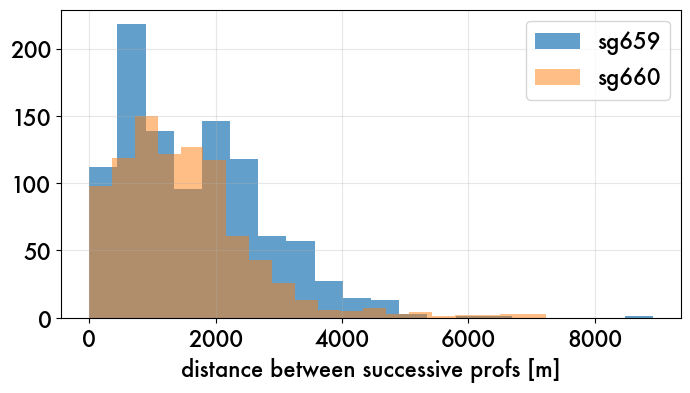

In [792]:
plt.figure(figsize=(8,4))
plt.hist(dav_660.daily_dist, bins=20, label='sg659', alpha=0.7)
plt.hist(dav_659.daily_dist, bins=20, label='sg660', alpha=0.5)
plt.legend()
plt.xlabel('distance between successive profs [m]')
plt.grid(zorder=0, alpha=0.3)

In [547]:
# def get_depth_bx(df_plat, dav_plat, d0=100, thresh=10):
#     rho0 = 1027 # reference density
#     buoyancy = lambda sigma0: -9.81 * (1 - ((sigma0 + 1000)/rho0) )
#     df_plat['B'] = buoyancy(df_plat.sigma0)

#     # create df of rows at 100m with valid buoyancy values
#     depth_bx = pd.DataFrame()
#     for ind, prof in enumerate(sg.list_profile_DFs(df_plat)):

#         # try changing this d0 to within the mixed layer 
#         d0 = dav_plat[ind].mld + 30

#     filtered_df = df[(df['distance'] >= (d0 - thresh)) & (df['distance'] <= (d0 + thresh))]
#     if len(filtered_df)>0:
#     # Find the row with the closest value of "distance" to 100
#         closest_row = filtered_df.iloc[(filtered_df['distance'] - d0).abs().idxmin()]
#         depth_bx = pd.concat([depth_bx, closest_row], axis=1, ignore_index=True)

#     depth_bx = depth_bx.T

#     #     temp = prof[prof.pressure<d0]
#     #     # if there are observations close to 100
#     #     if len(temp)>0:
#     #         row = temp.iloc[-1].copy() # deepest row under 100m
#     #         if row.pressure > (d0-thresh): # only add if deeper than 90m
#     #             depth_bx = pd.concat([depth_bx, row], axis=1, ignore_index=True)
#     # depth_bx = depth_bx.T


#     # Find distance between profiles which we know the buoyancies for
#     depth_bx['xdist'] = np.tile(0, len(depth_bx))
#     depth_bx.loc[1:, 'xdist'] = dist_between_profiles(depth_bx)

#     # Now take difference in B between successive profiles
#     depth_bx['Bx'] = np.tile(np.nan, len(depth_bx))
#     for i in np.arange(1, len(depth_bx), 1):
#         B1 = depth_bx.B[i-1]
#         B2 = depth_bx.B[i]
#         diff = np.abs(B2-B1)
#         dist = depth_bx.xdist[i]
#         depth_bx.at[i, 'Bx'] = diff/dist

#     return depth_bx


In [799]:
depth_bx[['profid', 'lat', 'lon', 'B', 'xdist']]

profid      lat      lon         B        xdist
0    6600000 -51.4945  30.0263  0.000502     0.000000
1    6600001 -51.4919    30.03  0.000457   386.261575
2    6600002 -51.4834  30.0477  0.000516  1547.663530
3    6600003  -51.479  30.0534  0.000456   628.631513
4    6600004 -51.4701  30.0692   0.00042  1475.419457
..       ...      ...      ...       ...          ...
994  6601009 -51.5504   38.932  0.002232  3043.575271
995  6601010 -51.5466  38.9332  0.002231   430.611441
996  6601011 -51.5363   38.983  0.002219  3629.490305
997  6601012 -51.5337  38.9882  0.002213   461.460515
998  6601013  -51.519  39.0301  0.002211  3327.772048

[999 rows x 5 columns]

In [800]:
dav_660.daily_dist

0          0.000000
1        398.002283
2       1568.625184
3        578.539923
4       1625.130990
           ...     
1003    1641.026047
1004    1801.090733
1005    1915.030615
1006    2109.633344
1007    1721.725532
Name: daily_dist, Length: 1008, dtype: float64

In [827]:
df_plat = df_660 
dav_plat = dav_660
d0=50
thresh=20

dav_plat[dav_plat.profid==6600005]

profid     yearday        lat        lon         mld      eke  eke_avg  \
5  6600005  119.592997 -51.461778  30.076578  116.042391  0.32485  0.21851   

        par  daily_dist  
5  5.083996  934.284301

## finding ref rho in a few ways

In [968]:
# Find mean sigma (reference rho) at chosen d0
def d0_mean_sigma(df_plat, d0=50, thresh=5):
    result = []
    for ind, prof in enumerate(sg.list_profile_DFs(df_plat)):
        filtered_df = prof[(prof['pressure'] >= (d0 - thresh)) & (prof['pressure'] <= (d0 + thresh))].copy()
        result.append(filtered_df.sigma0.mean())
    return result

# reference mean density, from just around chosen d0 
ls = np.array(d0_mean_sigma(df_plat, d0=50, thresh=5))
print(np.nanmean(ls))

# if you want to reference mean of entire water column
print(np.nanmean(df_plat.sigma0))


27.15355581299716
27.59259584413856


In [1291]:
# Find mean sigma (reference rho) in just mixed layer
def ml_mean_rho(df_plat):
    result = []
    for ind, prof in enumerate(sg.list_profile_DFs(df_plat)):
        # Find potential density within mixed layer
        mldepth = dav_plat.iloc[ind].mld.item()
        if not np.isnan(mldepth):
            upperprof = prof[(prof.pressure < (mldepth+5))]
            rho_ref = upperprof.sigma0.mean() + 1000
        else:
            rho_ref = np.nan
        result.append(rho_ref)
    return np.nanmean(result)

# Average sigma in ML across all 
# print(ml_mean_rho(df_659))
# print(ml_mean_rho(df_660))

# Average sigma in ML across all 
print(np.nanmean(df_659.sigma0) + 1000)
print(np.nanmean(df_660.sigma0) + 1000)

1027.0358176940783
1027.1601284610115
1027.465966371444
1027.5925958441385


In [981]:
# VERSION 1: Specify a mean rho from around d0. 
#  Calculate b from around chosen depth d0 (rather than mean b for whole ML)
# Try again with different reference density 

df_plat = df_660 
dav_plat = dav_660
d0=50
thresh=5

def get_d0_bx(df_plat, dav_plat, d0 = 50, thresh=20):
    """ 
    Find horiz buoyancy gradient at chosen depth (in mixed layer)
    @param:     df_plat     glider DataFrame
                dav_plat    dive-averaged glider DF
                d0          depth at which to calculate Bx
                thresh      acceptable threshold away from d0
    @return:    depth_bx    DF with Bx values at chosen d0
    """
    depth_bx = pd.DataFrame()
    for ind, prof in enumerate(sg.list_profile_DFs(df_plat)):
        # Reference density at depth d0=50, th5
        # mean of depth_bx at depth d0=50, th5
        rho_ref = 27.15355581299716 + 1000
        # rho_ref = 27.59259584413856 +1000

        # Filter profile DF into rows within depth threshold
        filtered_df = prof[(prof['pressure'] >= (d0 - thresh)) & (prof['pressure'] <= (d0 + thresh))].copy()
        filtered_df['b'] = np.tile(np.nan, len(filtered_df))

        # If we have obs around d0, and we have a potential density
        if (len(filtered_df)>0) & (not np.isnan(rho_ref)):
            buoyancy = lambda sigma0: 9.81 * (1 - ((sigma0 + 1000)/rho_ref) )
            filtered_df.loc[:, 'b'] = buoyancy(df_plat.sigma0)
            # Find the row with the closest value of "pressure" to chosen d0
            closest_row = filtered_df.loc[(filtered_df['pressure'] - d0).abs().idxmin()]
            depth_bx = pd.concat([depth_bx, closest_row], axis=1)

    depth_bx = depth_bx.T

    # # Add distance (m) between profiles
    dist = dist_between_profiles(depth_bx)
    depth_bx = depth_bx.reset_index()
    depth_bx['xdist'] = np.tile(0, len(depth_bx))
    depth_bx.loc[1:, 'xdist'] = dist

    # # Now take hz difference in B between successive profiles
    depth_bx['bx'] = np.tile(np.nan, len(depth_bx))
    for i in np.arange(1, len(depth_bx), 1):
        B1 = depth_bx.b[i-1]
        B2 = depth_bx.b[i]
        diff = np.abs(B2-B1)
        dist = depth_bx.xdist[i]
        depth_bx.at[i, 'bx'] = diff/dist

    return depth_bx
    


/var/folders/nt/sjynqxjj7cz9r15fkd5d4r_40000gn/T/ipykernel_3609/1914994244.py:7: RuntimeWarning: Mean of empty slice
  rho = np.nanmean(prof[prof.pressure<100].sigma0) + 1000


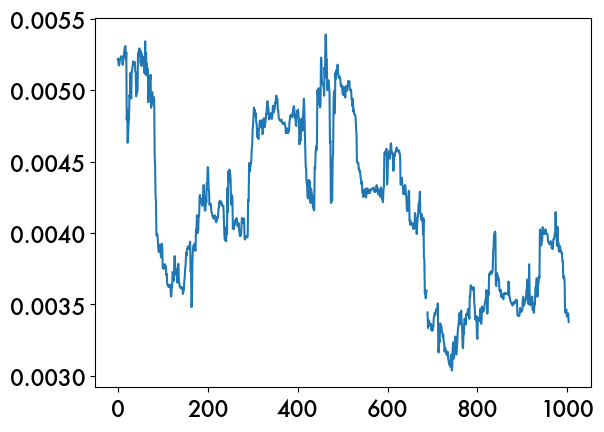

In [1125]:
df_plat = df_660
b_list = []  
rho_ref = np.nanmean(df_plat.sigma0) + 1000
# rho_ref =  ml_mean_rho(df_plat) 

for ind, prof in enumerate(sg.list_profile_DFs(df_plat)):
    rho = np.nanmean(prof[prof.pressure<100].sigma0) + 1000
    b_list.append(9.81 * (1 - (rho/rho_ref) ))
    
plt.plot(b_list)

# better mld density based bx calculation

In [1213]:
rho_list = []
for ind, prof in enumerate(sg.list_profile_DFs(df_plat)):
    mldepth = dav_plat.mld.iloc[ind]
    profind = int(str(prof.profid.values[0])[-4:])

    if (not np.isnan(mldepth)) & (profind < len(dav_plat)):
        upperprof = prof[(prof.pressure < (mldepth+1))]
        rho = np.nanmean(upperprof.sigma0) + 1000
        rho_list.append(rho)
        # print(rho)
        # result.loc[profind, 'b'] = 9.81 * (1 - (rho/rho_ref) )
rho_list = np.array(rho_list)

# range of observed sigmas above ml
rho_list = np.array(rho_list)
rho_list.max() - rho_list.min()

0.23200142805626456

In [1231]:
depth_bx

Empty DataFrame
Columns: []
Index: []

In [1233]:
# ALTERNATE VERSION
# VERSION 2: Specify a mean rho from points above MLD
# Calculate b from around chosen depth d0 (rather than mean b for whole ML)
# Use center difference for slight smoothing 

def get_ml_bx(df_plat, dav_plat, rho_ref):
    """ 
    Find horiz buoyancy gradient at chosen depth (in mixed layer)
    @param:     df_plat     glider DataFrame
                dav_plat    dive-averaged glider DF
                rho_ref     reference density for buoyancy calculation
    @return:    depth_bx    DF with Bx values at chosen d0
    """
    result = dav_plat.copy()
    result['b'] = np.tile(np.nan, len(result))

    # Find density within mixed layer for each glider profile
    for ind, prof in enumerate(sg.list_profile_DFs(df_plat)):
        mldepth = dav_plat.mld.iloc[ind]
        profind = int(str(prof.profid.values[0])[-4:])

        if (not np.isnan(mldepth)) & (profind < len(dav_plat)):
            upperprof = prof[(prof.pressure < (mldepth+1))]
            rho = np.nanmean(upperprof.sigma0) + 1000
            # Buoyancy calculation
            result.loc[profind, 'b'] = 9.81 * (1 - (rho/rho_ref) )


    # Add horizontal distance (x, in m) between profiles
    # result = result.reset_index()
    result['xdist'] = np.tile(0, len(result))
    result.loc[1:, 'xdist'] = dist_between_profiles(result)

    # Horizontal buoyancy gradient calculation as deltaB/deltaX
    result['bx'] = np.tile(np.nan, len(result))
    for i in np.arange(1, len(result)-1, 1):
        delta_b = result['b'].iloc[i+1] - result['b'].iloc[i-1]
        delta_x = result['xdist'].iloc[i] + result['xdist'].iloc[i+1]
        result.loc[i, 'bx'] = np.abs(delta_b)/delta_x

    return result
  

In [805]:
df_plat = df_660 
dav_plat = dav_660
d0=50
thresh=20

def get_mixedlayer_bx(df_plat, dav_plat, d0 = 50, thresh=20):
    """ 
    Find horiz buoyancy gradient at chosen depth (in mixed layer)
    @param:     df_plat     glider DataFrame
                dav_plat    dive-averaged glider DF
                d0          depth at which to calculate Bx
                thresh      acceptable threshold away from d0
    @return:    depth_bx    DF with Bx values at chosen d0
    """
    # Add buoyancy to glider DF, by profile: 
    rho0_by_prof = []

    for ind, prof in enumerate(sg.list_profile_DFs(df_plat)):
        mldepth = dav_plat.iloc[ind].mld.item()
        upperprof = prof[(prof.pressure < mldepth)]
        rho_ref = upperprof.sigma0.mean() + 1000 

        filtered_df = prof[(prof['pressure'] >= (d0 - thresh)) & (prof['pressure'] <= (d0 + thresh))]
        if len(filtered_df)>0:
        # Find the row with the closest value of "pressure" to chosen d0
            closest_row = filtered_df.loc[(filtered_df['pressure'] - d0).abs().idxmin()]

        rho_insitu = closest_row.sigma0.item()
        closest_row['b'] = 

        sigma_at_d0 = 
        b = -9.81 * (1 - ((sigma0 + 1000)/rho0) )


    df_plat.iloc[ ,]

    rho0 = 1027
    buoyancy = lambda sigma0: -9.81 * (1 - ((sigma0 + 1000)/rho0) )
    df_plat.iloc[df_plat.profid==, 'B'] = buoyancy(df_plat.sigma0)

    # Create DF of rows corresponding to profiles with valid B
    depth_bx = pd.DataFrame()
    for ind, prof in enumerate(sg.list_profile_DFs(df_plat)):
        filtered_df = prof[(prof['pressure'] >= (d0 - thresh)) & (prof['pressure'] <= (d0 + thresh))]
        if len(filtered_df)>0:
        # Find the row with the closest value of "pressure" to chosen d0
            closest_row = filtered_df.loc[(filtered_df['pressure'] - d0).abs().idxmin()]
            depth_bx = pd.concat([depth_bx, closest_row], axis=1)
    depth_bx = depth_bx.T


    # # Add distance (m) between profiles
    dist = dist_between_profiles(depth_bx)
    depth_bx = depth_bx.reset_index()
    depth_bx['xdist'] = np.tile(0, len(depth_bx))
    depth_bx.loc[1:, 'xdist'] = dist

    # # Now take hz difference in B between successive profiles
    depth_bx['Bx'] = np.tile(np.nan, len(depth_bx))
    for i in np.arange(1, len(depth_bx), 1):
        B1 = depth_bx.B[i-1]
        B2 = depth_bx.B[i]
        diff = np.abs(B2-B1)
        dist = depth_bx.xdist[i]
        depth_bx.at[i, 'Bx'] = diff/dist

    return depth_bx



# def get_mixedlayer_bx(df_plat, dav_plat, d0 = 50, above = 30, thresh=20):
#     rho0 = 1027
#     buoyancy = lambda sigma0: -9.81 * (1 - ((sigma0 + 1000)/rho0) )
#     df_plat['B'] = buoyancy(df_plat.sigma0)

#     # Create DF of rows corresponding to profiles with valid B
#     depth_bx = pd.DataFrame()
#     for ind, prof in enumerate(sg.list_profile_DFs(df_plat)):
#         filtered_df = prof[(prof['pressure'] >= (d0 - thresh)) & (prof['pressure'] <= (d0 + thresh))]
#         if len(filtered_df)>0:
#         # Find the row with the closest value of "pressure" to chosen d0
#             closest_row = filtered_df.loc[(filtered_df['pressure'] - d0).abs().idxmin()]
#             depth_bx = pd.concat([depth_bx, closest_row], axis=1)
#     depth_bx = depth_bx.T

#     # Add distance (m) between profiles
#     depth_bx = depth_bx.reset_index()
#     depth_bx['xdist'] = np.tile(0, len(depth_bx))
#     depth_bx.loc[1:, 'xdist'] = dist_between_profiles(depth_bx)

#     # Now take hz difference in B between successive profiles
#     depth_bx['Bx'] = np.tile(np.nan, len(depth_bx))
#     for i in np.arange(1, len(depth_bx), 1):
#         B1 = depth_bx.B[i-1]
#         B2 = depth_bx.B[i]
#         diff = np.abs(B2-B1)
#         dist = depth_bx.xdist[i]
#         depth_bx.at[i, 'Bx'] = diff/dist

#     return depth_bx

# if d0 == None: # if selecting
        #     d0 = dav_plat.iloc[ind].mld - above

In [650]:
# def dist_between_profiles(dav):
#     cind = list(np.arange(0,len(dav),1))

#     la1 = dav.lat.iloc[cind[:-1]]
#     lo1 = dav.lon.iloc[cind[:-1]]
#     la2 = dav.lat.iloc[cind[1:]]
#     lo2 = dav.lon.iloc[cind[1:]]

#     # make pairs
#     result = []

#     for ind in np.arange(0, len(lo1), 1):
#         loc1=(la1.iloc[ind], lo1.iloc[ind])
#         loc2=(la2.iloc[ind], lo2.iloc[ind])
#         result.append(hs.haversine(loc1,loc2,unit=Unit.METERS))

#     return result

# # dist_between_profiles(depth_bx)

# when troubleshooting

In [1048]:
d0 = 30
thresh = 5

bx30_659 = get_ml_bx(df_659, dav_659, d0=d0, thresh=thresh)
bx30_660 = get_ml_bx(df_660, dav_660, d0=d0, thresh=thresh)

/var/folders/nt/sjynqxjj7cz9r15fkd5d4r_40000gn/T/ipykernel_3609/2187062654.py:28: RuntimeWarning: Mean of empty slice
  rho = np.nanmean(upperprof.sigma0) + 1000


In [762]:
# # after changing buoyancy def
#  still problem with distances where sometimes we're dividing by a large distance if we skipped a profile or a few 
dir = '../working-vars/ML-variability/'
# bx100_659.to_csv('../working-vars/ML-variability/bx100_659.csv', index=False)
# bx100_660.to_csv('../working-vars/ML-variability/bx100_660.csv', index=False)

Text(0, 0.5, 'Bx [1/s2]')

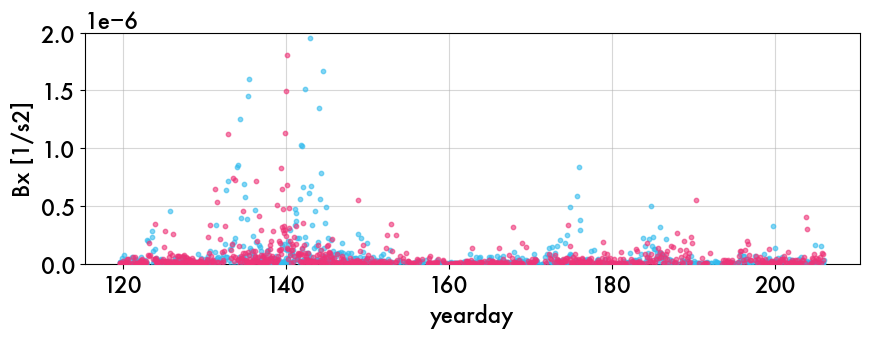

In [1050]:
fig = plt.figure(figsize=(10,3))
ax = fig.gca()

ax.scatter(bx30_659.yearday, np.abs(bx30_659.bx), label='glider 659', s=10, alpha=0.6, color=plat_colors['sg659'], zorder=3)
ax.scatter(bx30_660.yearday, np.abs(bx30_660.bx), label='glider 660', s=10, alpha=0.6, color=plat_colors['sg660'], zorder=3)
# ax.scatter(depth_bx.yearday, np.abs(depth_bx.bx), label='glider 660', s=10, alpha=0.6, color=plat_colors['sg660'], zorder=3)
ax.grid(zorder=0, alpha=0.5)
ax.set_ylim([0, 2e-06])

# ax.set_title('Bx at d0=' + str(d0))
ax.set_xlabel('yearday')
ax.set_ylabel('Bx [1/s2]')



In [ ]:
d0 = 50
thresh = 5
bx_659 = get_d0_bx(df_659, dav_659, d0=d0, thresh=thresh)
bx_660 = get_d0_bx(df_660, dav_660, d0=d0, thresh=thresh)


In [1176]:
bx_659 = get_ml_bx(df_659, dav_659, rho_ref = np.nanmean(df_659.sigma0) + 1000)
bx_659.b.max() - bx_659.b.min() 

0.002290397895389821

In [1147]:
bx_659 = get_ml_bx(df_659, dav_659, rho_ref = ml_mean_rho(df_659))
bx_659.b.max() - bx_659.b.min() 

0.0022913571721841497

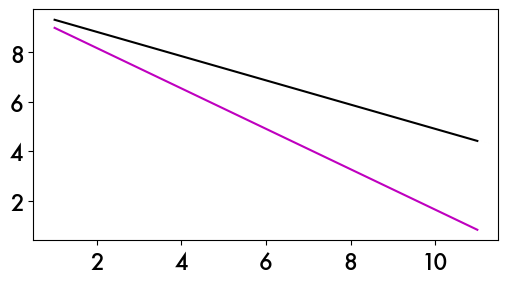

In [1215]:
# rho_ref = 1027.35
fig = plt.figure(figsize=(6,3))
ax = fig.gca()


# xlist = np.arange(1026.5, 1028, 0.1)
xlist = np.arange(1, 12, 2)

rho_ref = 12
buoyancy = lambda x: (9.81 * (1 - x/rho_ref))
ylist = [buoyancy(x) for x in xlist]
plt.plot(xlist, ylist, c='m', label = str(rho_ref))

rho_ref = 20
buoyancy = lambda x: (9.81 * (1 - x/rho_ref))
ylist = [buoyancy(x) for x in xlist]
plt.plot(xlist, ylist, c='k', label = str(rho_ref))






Text(0.5, 1.0, 'dependence of b on mean_rho0')

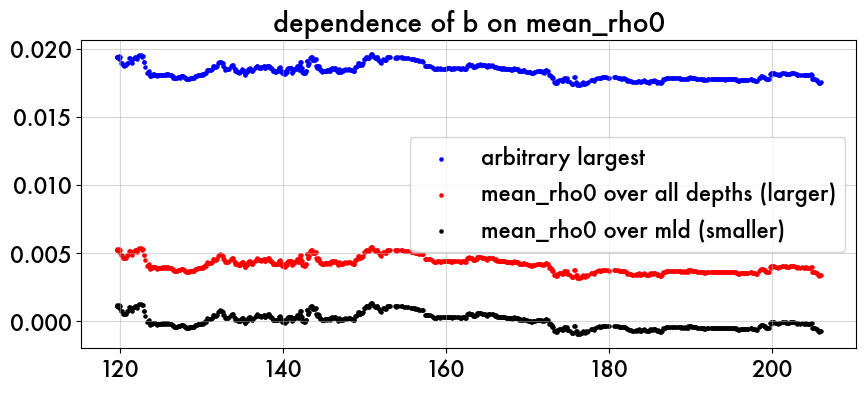

In [1212]:
# for b over choice rho_ref
fig = plt.figure(figsize=(10,4))
ax = plt.gca()


# bx_659 = get_ml_bx(df_659, dav_659, rho_ref = 1028.95)
# plt.scatter(bx_659.yearday, bx_659.b, marker='o', s=5, c='b', label = 'arbitrary largest')

bx_659 = get_ml_bx(df_659, dav_659, rho_ref = np.nanmean(df_659.sigma0) + 1000)
plt.scatter(bx_659.yearday, bx_659.b, marker='o', s=5, c='r', label = 'mean_rho0 over all depths (larger)')

bx_659 = get_ml_bx(df_659, dav_659, rho_ref = ml_mean_rho(df_659))
plt.scatter(bx_659.yearday, bx_659.b, marker='o', s=5, c='k', label = 'mean_rho0 over mld (smaller)')

ax.grid(zorder=0, alpha=0.5)
ax.legend()
ax.set_title('dependence of b on mean_rho0')

# ax.set_ylim([0, 1e-9])


Text(0.5, 1.0, 'diff in bx depending on mean-rho0 (above mld or all depths)')

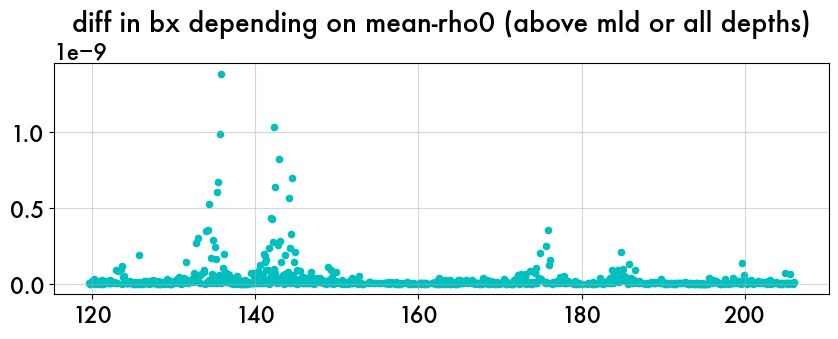

In [1211]:
# for bx over choice rho_ref
fig = plt.figure(figsize=(10,3))
ax = plt.gca()

# bx_659['bx_ml'] = get_ml_bx(df_659, dav_659, rho_ref = ml_mean_rho(df_659)).bx
# bx_659['bx_all'] = get_ml_bx(df_659, dav_659, rho_ref = np.nanmean(df_659.sigma0) + 1000).bx


plt.scatter(bx_659.yearday, (bx_659.bx_ml - bx_659.bx_all), marker='o', s=20, c='c', label = 'mean_rho0 over all depths (larger)')
ax.grid(zorder=0, alpha=0.5)
ax.set_title('diff in bx depending on mean-rho0 (above mld or all depths)')



In [ ]:

bx_660 = get_ml_bx(df_660, dav_660, rho_ref = np.nanmean(df_660.sigma0) + 1000)
plt.plot(bx_660.bx)

# check plot

In [1311]:
from mod_plot import *

In [1328]:
dav_659

profid     yearday        lat        lon         mld       eke  \
0    6590000  119.585031 -51.494618  30.048702         NaN  0.337256   
1    6590001  119.592706 -51.491504  30.054853         NaN  0.336052   
2    6590002  119.619936 -51.480539  30.077068  106.706000  0.331958   
3    6590003  119.631899 -51.475917  30.088078  108.472375  0.330315   
4    6590004  119.689304 -51.449310  30.141417   92.323833  0.314054   
..       ...         ...        ...        ...         ...       ...   
907  6590907  205.591044 -51.722662  38.912155  173.587000  0.063737   
908  6590908  205.704530 -51.719360  38.927557  177.120750  0.065028   
909  6590909  205.806132 -51.715944  38.949354  154.404400  0.066580   
910  6590910  205.921993 -51.710122  38.972913  150.366333  0.068600   
911  6590911  206.026239 -51.703824  38.989142  144.308667  0.070357   

      eke_avg       par   daily_dist  
0    0.217549  5.083996     0.000000  
1    0.218243  5.083996   548.846630  
2    0.220802  5.083996  1962.825241  
3    0.222178  5.665997   919.462723  
4    0.224623  5.087997  4733.642708  
..        ...       ...          ...  
907  0.083008  6.767998  1186.859108  
908  0.081539  6.499996  1122.739581  
909  0.079422  6.499996  1548.819506  
910  0.077173  6.303997  1747.493191  
911  0.075665  6.511997  1319.469482  

[912 rows x 9 columns]

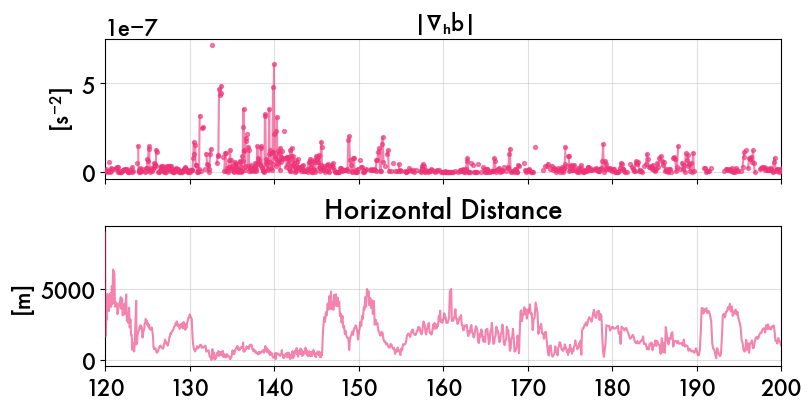

In [1335]:

# bx_659 = get_ml_bx(df_659, dav_659, rho_ref = np.nanmean(df_659.sigma0) + 1000)
# bx_660 = get_ml_bx(df_660, dav_660, rho_ref = np.nanmean(df_660.sigma0) + 1000)

fig, axs = plt.subplots(2,1, figsize=(8,4), sharex=True, layout='constrained') # 14,12
axs = axs.flatten()
dotsize=8

ind = 0
for ax in axs[ind:ind+1]:
    # ax.scatter(bx_659.yearday, np.abs(bx_659.bx), label='sg659', s=dotsize, alpha=0.6, color=plat_colors['sg659'], zorder=3)
    ax.scatter(bx_660.yearday, np.abs(bx_660.bx), label='sg660', s=dotsize, alpha=0.6, color=plat_colors['sg660'], zorder=3)
    ax.plot(bx_660.yearday, np.abs(bx_660.bx), label='sg660', alpha=0.6, color=plat_colors['sg660'], zorder=3)
    ax.set_ylabel(hb_unit) 
    ax.set_title(hb_title, fontsize=titlesize) # @ (at 100m)
    # ax.set_ylim([0, 1e-06])
    # ax.set_yscale('log')
    # ax.legend(fontsize=10)

ind = ind+1
for ax in axs[ind:ind+1]:
    # ax.scatter(bx_659.yearday, np.abs(bx_659.bx), label='glider 659', s=dotsize, alpha=0.6, color=plat_colors['sg659'], zorder=3)
    ax.plot(dav_660.yearday, np.abs(dav_660.xdist), label='glider 660', alpha=0.6, color=plat_colors['sg660'], zorder=3)
    ax.set_title('Horizontal Distance')
    ax.set_ylabel('[m]')

    # ax.set_ylim([0, 2e-07])


# ind = ind+1
# for ax in axs[ind:ind+1]:
#     # ax.scatter(bx_659.yearday, np.abs(bx_659.b), label='glider 659', s=dotsize, alpha=0.6, color=plat_colors['sg659'], zorder=3)
#     ax.scatter(bx_660.yearday, np.abs(bx_660.b), label='glider 660', s=dotsize, alpha=0.6, color=plat_colors['sg660'], zorder=3)
#     ax.set_title('b', fontsize=titlesize)



# ind = ind+1
# for ax in axs[ind:ind+1]:
#     # ax.scatter(hvariance_659.yearday, hvariance_659.nitrate_mean, label='sg659', s=dotsize+4, alpha=0.6, color=plat_colors['sg659'])
#     ax.set_ylabel(umol_unit_squared) 
#     ax.scatter(hvariance_660.yearday, hvariance_660.nitrate_mean, label='sg660', s=dotsize+4, alpha=0.6, color=plat_colors['sg660'])
#     ax.set_ylim([-.05, 0.47])
#     ax.set_title(hvar_title, fontsize=titlesize)


for ax in axs:
    ax.grid(zorder=0, alpha=0.4)
    ax.set_xlim([120,200])
    # ax.legend()

    # ax.vlines(150, -30,250, color='r', linewidth=1.8, alpha=0.5, linestyle='dashed', zorder=1)
    # ax.vlines(170, -30,250, color='k', linewidth=1.8, alpha=0.5, linestyle='dashed', zorder=1)



/var/folders/nt/sjynqxjj7cz9r15fkd5d4r_40000gn/T/ipykernel_3609/3805180779.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(str(ytd2datetime(k))[-5:] for k in xt)
/var/folders/nt/sjynqxjj7cz9r15fkd5d4r_40000gn/T/ipykernel_3609/3805180779.py:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['01-May', '11-May', '21-May', '31-May',


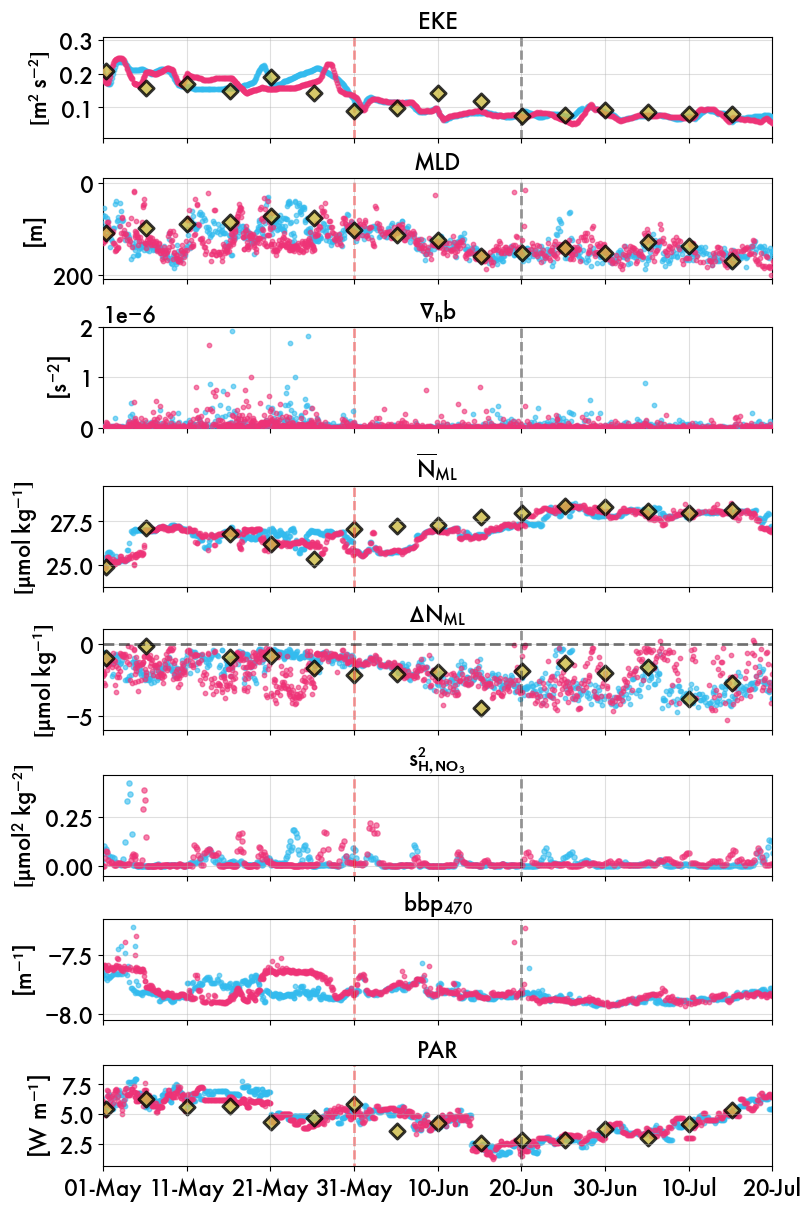

In [951]:
dotsize=10; diasize=60; titlesize=16

fig, axs = plt.subplots(8,1, figsize=(8,12), sharex=True, layout='constrained') # 14,12
axs = axs.flatten()

ind = 0
for ax in axs[ind:ind+1]:
    ax.scatter(dav_659.yearday, dav_659.eke_avg, s=dotsize, alpha=0.6, color=plat_colors['sg659'], zorder=3)
    ax.scatter(dav_660.yearday, dav_660.eke_avg, s=dotsize, alpha=0.6, color=plat_colors['sg660'], zorder=3)
    ax.scatter(dav_float.yearday, dav_float.eke_avg,  marker='D', edgecolors='k', linewidth=2.1,
            s=diasize, alpha=0.8, color='#CCBB44', zorder=3)
    ax.set_ylabel(eke_unit) 
    ax.set_title('EKE', fontsize=titlesize)
    # ax.set_ylim([-.05, 0.72]) # for eke
    ax.set_ylim([.01, 0.31]) # for eke_avg

ind = ind+1
for ax in axs[ind:ind+1]:
    ax.scatter(mlstat_659.yearday, mlstat_659.mld, s=dotsize, alpha=0.6, color=plat_colors['sg659'], zorder=3)
    ax.scatter(mlstat_660.yearday, mlstat_660.mld, s=dotsize, alpha=0.6, color=plat_colors['sg660'], zorder=3)
    ax.scatter(dav_6030.yearday, dav_6030.mld, label='float',  marker='D', edgecolors='k', linewidth=2.1,
            s=diasize, alpha=0.8, color='#CCBB44', zorder=3)
    
    ax.set_ylabel('[m]')
    ax.invert_yaxis()
    ax.set_ylim([210, -10])
    ax.set_title(('MLD'), fontsize=titlesize)
    
    
ind = ind+1
for ax in axs[ind:ind+1]:
    ax.scatter(bx_659.yearday, np.abs(bx_659.bx), label='glider 659', s=dotsize, alpha=0.6, color=plat_colors['sg659'], zorder=3)
    ax.scatter(bx_660.yearday, np.abs(bx_660.bx), label='glider 660', s=dotsize, alpha=0.6, color=plat_colors['sg660'], zorder=3)
    ax.set_ylabel(hb_unit) 
    ax.set_title(hb_title, fontsize=titlesize) # @ (at 100m)
    ax.set_ylim([0, 2e-06])
    # ax.legend(fontsize=16, markerscale=2.5)
# axs[0].scatter(df_659.yearday, df_659.pressure, c=df_659.nitrate, s=5, cmap=cmo.deep, zorder=1)


ind = ind+1
for ax in axs[ind:ind+1]:
    ax.scatter(mlstat_659.yearday, mlstat_659.nitrate_mean, label='sg659', s=dotsize, alpha=0.6, color=plat_colors['sg659'])
    ax.scatter(mlstat_660.yearday, mlstat_660.nitrate_mean, label='sg660', s=dotsize, alpha=0.6, color=plat_colors['sg660'])
    ax.scatter(mlstat_float.yearday, mlstat_float.nitrate_mean, label='float',  marker='D', edgecolors='k', linewidth=2.1,
            s=diasize, alpha=0.8, color='#CCBB44')
    ax.set_ylabel(umol_unit)
    ax.set_ylim([23.7, 29.5])
    ax.set_title(overline_title, fontsize=titlesize) 

    # to run once for paper fig legend:
    # if legend:
    #     ax.legend(markerscale=1, ncol=3)

ind = ind+1
for ax in axs[ind:ind+1]:
    ax.scatter(mlstat_659.yearday, mlstat_659.nitrate_cross, label='sg659', s=dotsize, alpha=0.6, color=plat_colors['sg659'])
    ax.scatter(mlstat_660.yearday, mlstat_660.nitrate_cross, label='sg660', s=dotsize, alpha=0.6, color=plat_colors['sg660'])
    ax.scatter(mlstat_float.yearday, mlstat_float.nitrate_cross, label='float',  marker='D', edgecolors='k', linewidth=2.1,
                s=diasize, alpha=0.8, color='#CCBB44')
    ax.set_ylabel(umol_unit)
    ax.hlines(0, 120, 200, linestyle='--', linewidth=2.1, color='k', alpha=0.5)
    ax.set_ylim([-6, 1])
    ax.set_title(delta_title, fontsize=titlesize)
    
ind = ind+1
for ax in axs[ind:ind+1]:
    ax.scatter(hvariance_659.yearday, hvariance_659.nitrate_mean, label='sg659', s=dotsize+4, alpha=0.6, color=plat_colors['sg659'])
    ax.set_ylabel(umol_unit_squared) 
    ax.scatter(hvariance_660.yearday, hvariance_660.nitrate_mean, label='sg660', s=dotsize+4, alpha=0.6, color=plat_colors['sg660'])
    ax.set_ylim([-.05, 0.47])
    ax.set_title(hvar_title, fontsize=titlesize)


ind = ind+1
for ax in axs[ind:ind+1]:
    ax.scatter(mlstat_659.yearday, np.log(mlstat_659.bbp470_mean), label='sg659', s=dotsize, color=plat_colors['sg659'], alpha=0.6)
    ax.scatter(mlstat_660.yearday, np.log(mlstat_660.bbp470_mean), label='sg660', s=dotsize, color=plat_colors['sg660'], alpha=0.6)
    ax.set_ylabel(backscatter_unit) 
    ax.set_ylim([-8.05, -7.2])
    ax.set_title(bbp_title, fontsize=titlesize)

ind = ind+1
for ax in axs[ind:ind+1]:
    ax.scatter(dav_659.yearday, dav_659.par, label='par', s=dotsize, alpha=0.6, color=plat_colors['sg659'])
    ax.scatter(dav_660.yearday, dav_660.par, label='par', s=dotsize, alpha=0.6, color=plat_colors['sg660'])
    ax.scatter(dav_float.yearday, dav_float.par, label='par', s=diasize, alpha=0.8, color=plat_colors['float'],
            marker='D', edgecolors='k', linewidth=2.1)
    ax.set_ylabel(par_unit) # PAR
    ax.set_ylim([0.6, 9.1])
    ax.set_title('PAR', fontsize=titlesize) 


xt = np.arange(120,210,10)
if dateformat: 
    for ax in axs[-1:]:
        ax.set_xticklabels(str(ytd2datetime(k))[-5:] for k in xt)
        ax.set_xticklabels(['01-May', '11-May', '21-May', '31-May',
                            '10-Jun', '20-Jun', '30-Jun', 
                            '10-Jul', '20-Jul'])
else:
    for ax in axs[-1:]:
        ax.set_xlabel('[Yearday]')

for ax in axs:
    ax.grid(zorder=0, alpha=0.4)
    ax.set_xlim([120,200])
    # ax.legend()

    ax.vlines(150, -30,250, color='r', linewidth=1.8, alpha=0.5, linestyle='dashed', zorder=1)
    ax.vlines(170, -30,250, color='k', linewidth=1.8, alpha=0.5, linestyle='dashed', zorder=1)

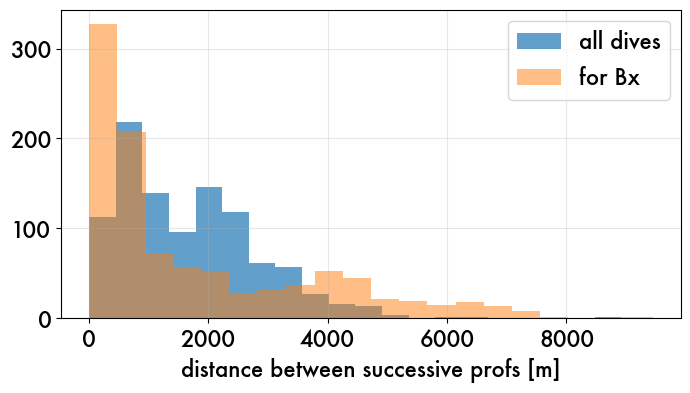

In [810]:
plt.figure(figsize=(8,4))
plt.hist(dav_660.daily_dist, bins=20, label='all dives', alpha=0.7)
plt.hist(depth_bx.xdist, bins=20, label='for Bx', alpha=0.5)
plt.legend()
plt.xlabel('distance between successive profs [m]')
plt.grid(zorder=0, alpha=0.3)

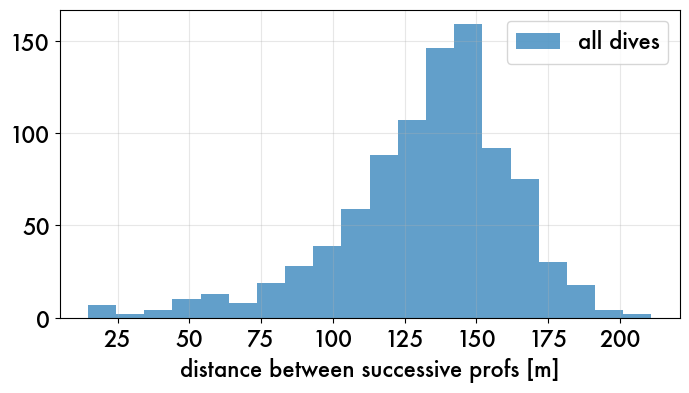

In [818]:
plt.figure(figsize=(8,4))
plt.hist(dav_660.mld, bins=20, label='all dives', alpha=0.7)
plt.legend()
plt.xlabel('distance between successive profs [m]')
plt.grid(zorder=0, alpha=0.3)

### MLSTAT

In [1319]:
dir = '../working-vars/ML-variability/'
mlstat_659 = pd.read_csv( dir +'mixedlayerstat_659_may24.csv', index_col=0)
mlstat_660 = pd.read_csv( dir +'mixedlayerstat_660_may24.csv', index_col=0)


In [1320]:
for ind, profnum in enumerate(mlstat_659.profid.values):
    if profnum in bx_659.profid.values:
        mlstat_659.at[ind, 'b'] = bx_659[bx_659.profid==profnum].b.values[0]
        mlstat_659.at[ind, 'bx'] = bx_659[bx_659.profid==profnum].bx.values[0]
for ind, profnum in enumerate(mlstat_660.profid.values):
    if profnum in bx_660.profid.values:
        mlstat_660.at[ind, 'b'] = bx_660[bx_660.profid==profnum].b.values[0]
        mlstat_660.at[ind, 'bx'] = bx_660[bx_660.profid==profnum].bx.values[0]


In [716]:
# add the daily distance to mlstat_660
mlstat_660['daily_dist'] = np.tile(0, len(mlstat_660))
mlstat_660.loc[1:, 'daily_dist'] = dist_between_profiles(mlstat_660)
mlstat_660

Unnamed: 0   profid     yearday        lat        lon         mld  \
0              0  6600000  119.512166 -51.494597  30.026178         NaN   
1              1  6600001  119.520193 -51.491895  30.029948         NaN   
2              2  6600002  119.545818 -51.483298  30.047911   80.011900   
3              3  6600003  119.554394 -51.479151  30.052956         NaN   
4              4  6600004  119.578450 -51.469120  30.070021         NaN   
...          ...      ...         ...        ...        ...         ...   
1003        1003  6601009  205.480558 -51.554121  38.922846  158.945000   
1004        1004  6601010  205.599403 -51.545629  38.945027  162.478667   
1005        1005  6601011  205.700063 -51.540221  38.971318  152.887700   
1006        1006  6601012  205.819512 -51.531987  38.998797  148.344667   
1007        1007  6601013  205.924983 -51.524550  39.020627  147.840000   

           par  nitrate_total  nitrate_mean  bbp470_total  bbp470_mean  \
0     4.971996            NaN           NaN           NaN          NaN   
1     4.971996            NaN           NaN           NaN          NaN   
2     5.083996   1.985488e+06     24.814907     40.073933     0.000501   
3     5.083996            NaN           NaN           NaN          NaN   
4     5.083996            NaN           NaN           NaN          NaN   
...        ...            ...           ...           ...          ...   
1003  6.843998   4.833568e+06     28.173227     67.509984     0.000393   
1004  6.843998   4.885818e+06     28.146542     68.408821     0.000394   
1005  6.287998   4.340559e+06     28.020417     61.202363     0.000395   
1006  6.287998   4.266831e+06     28.000639     60.646009     0.000398   
1007  5.805996   4.478818e+06     28.178417     62.407578     0.000393   

      oxygen_total  oxygen_mean  nitrate_cross  nitrate_underML  log_buoyancy  \
0              NaN          NaN            NaN              NaN           NaN   
1              NaN          NaN            NaN              NaN           NaN   
2     2.671936e+07   333.942376            NaN              NaN    -12.052550   
3              NaN          NaN            NaN              NaN           NaN   
4              NaN          NaN            NaN              NaN           NaN   
...            ...          ...            ...              ...           ...   
1003  5.696077e+07   332.004973       -2.57987        30.753097    -11.804571   
1004  5.775434e+07   332.715038            NaN              NaN    -10.763415   
1005  5.207222e+07   336.151504            NaN              NaN    -10.628645   
1006  5.128498e+07   336.552448            NaN              NaN    -11.860647   
1007  5.331781e+07   335.448195            NaN              NaN    -10.481176   

                Bx         B   daily_dist  
0              NaN       NaN     0.000000  
1              NaN       NaN   398.002283  
2              NaN  0.000565  1568.625184  
3              NaN  0.000672   578.539923  
4     2.753245e-08  0.000621  1625.130990  
...            ...       ...          ...  
1003  6.884440e-08  0.002488  1641.026047  
1004  6.067655e-08  0.002529  1801.090733  
1005  1.684547e-08  0.002474  1915.030615  
1006  2.037233e-07  0.002312  2109.633344  
1007  7.567697e-08  0.002541  1721.725532  

[1008 rows x 19 columns]

In [1321]:
mlstat_660

profid     yearday        lat        lon         mld       par  \
0     6600000  119.512166 -51.494597  30.026178         NaN  4.971996   
1     6600001  119.520193 -51.491895  30.029948         NaN  4.971996   
2     6600002  119.545818 -51.483298  30.047911   80.011900  5.083996   
3     6600003  119.554394 -51.479151  30.052956         NaN  5.083996   
4     6600004  119.578450 -51.469120  30.070021         NaN  5.083996   
...       ...         ...        ...        ...         ...       ...   
1003  6601009  205.480558 -51.554121  38.922846  158.945000  6.843998   
1004  6601010  205.599403 -51.545629  38.945027  162.478667  6.843998   
1005  6601011  205.700063 -51.540221  38.971318  152.887700  6.287998   
1006  6601012  205.819512 -51.531987  38.998797  148.344667  6.287998   
1007  6601013  205.924983 -51.524550  39.020627  147.840000  5.805996   

      nitrate_total  nitrate_mean  bbp470_total  bbp470_mean  oxygen_total  \
0               NaN           NaN           NaN          NaN           NaN   
1               NaN           NaN           NaN          NaN           NaN   
2      1.985488e+06     24.814907     40.073933     0.000501  2.671936e+07   
3               NaN           NaN           NaN          NaN           NaN   
4               NaN           NaN           NaN          NaN           NaN   
...             ...           ...           ...          ...           ...   
1003   4.833568e+06     28.173227     67.509984     0.000393  5.696077e+07   
1004   4.885818e+06     28.146542     68.408821     0.000394  5.775434e+07   
1005   4.340559e+06     28.020417     61.202363     0.000395  5.207222e+07   
1006   4.266831e+06     28.000639     60.646009     0.000398  5.128498e+07   
1007   4.478818e+06     28.178417     62.407578     0.000393  5.331781e+07   

      oxygen_mean  nitrate_cross  nitrate_underML  log_buoyancy   daily_dist  \
0             NaN            NaN              NaN           NaN     0.000000   
1             NaN            NaN              NaN           NaN   398.002283   
2      333.942376            NaN              NaN    -12.052550  1568.625184   
3             NaN            NaN              NaN           NaN   578.539923   
4             NaN            NaN              NaN           NaN  1625.130990   
...           ...            ...              ...           ...          ...   
1003   332.004973       -2.57987        30.753097    -11.804571  1641.026047   
1004   332.715038            NaN              NaN    -10.763415  1801.090733   
1005   336.151504            NaN              NaN    -10.628645  1915.030615   
1006   336.552448            NaN              NaN    -11.860647  2109.633344   
1007   335.448195            NaN              NaN    -10.481176  1721.725532   

             b            bx  
0          NaN           NaN  
1          NaN           NaN  
2     0.005181           NaN  
3          NaN           NaN  
4          NaN           NaN  
...        ...           ...  
1003  0.003558  3.074637e-08  
1004  0.003548  5.108426e-08  
1005  0.003368  6.111084e-08  
1006  0.003302  2.073149e-08  
1007  0.003447           NaN  

[1008 rows x 18 columns]

In [1322]:
mlstat_659 = mlstat_659[['profid', 'yearday', 'lat', 'lon', 'mld', 'par',
       'nitrate_total', 'nitrate_mean', 'bbp470_total', 'bbp470_mean',
       'oxygen_total', 'oxygen_mean', 'nitrate_cross', 'nitrate_underML',
       'log_buoyancy', 'b', 'bx']]

mlstat_660 = mlstat_660[['profid', 'yearday', 'lat', 'lon', 'mld', 'par',
       'nitrate_total', 'nitrate_mean', 'bbp470_total', 'bbp470_mean',
       'oxygen_total', 'oxygen_mean', 'nitrate_cross', 'nitrate_underML',
       'log_buoyancy', 'b', 'bx']]

mlstat_659['xdist'] = np.tile(0, len(dav_659))
mlstat_659.loc[1:, 'xdist'] = dist_between_profiles(dav_659)

mlstat_660['xdist'] = np.tile(0, len(dav_660))
mlstat_660.loc[1:, 'xdist'] = dist_between_profiles(dav_660)


In [1253]:
mlstat_660

profid     yearday        lat        lon         mld       par  \
0     6600000  119.512166 -51.494597  30.026178         NaN  4.971996   
1     6600001  119.520193 -51.491895  30.029948         NaN  4.971996   
2     6600002  119.545818 -51.483298  30.047911   80.011900  5.083996   
3     6600003  119.554394 -51.479151  30.052956         NaN  5.083996   
4     6600004  119.578450 -51.469120  30.070021         NaN  5.083996   
...       ...         ...        ...        ...         ...       ...   
1003  6601009  205.480558 -51.554121  38.922846  158.945000  6.843998   
1004  6601010  205.599403 -51.545629  38.945027  162.478667  6.843998   
1005  6601011  205.700063 -51.540221  38.971318  152.887700  6.287998   
1006  6601012  205.819512 -51.531987  38.998797  148.344667  6.287998   
1007  6601013  205.924983 -51.524550  39.020627  147.840000  5.805996   

      nitrate_total  nitrate_mean  bbp470_total  bbp470_mean  oxygen_total  \
0               NaN           NaN           NaN          NaN           NaN   
1               NaN           NaN           NaN          NaN           NaN   
2      1.985488e+06     24.814907     40.073933     0.000501  2.671936e+07   
3               NaN           NaN           NaN          NaN           NaN   
4               NaN           NaN           NaN          NaN           NaN   
...             ...           ...           ...          ...           ...   
1003   4.833568e+06     28.173227     67.509984     0.000393  5.696077e+07   
1004   4.885818e+06     28.146542     68.408821     0.000394  5.775434e+07   
1005   4.340559e+06     28.020417     61.202363     0.000395  5.207222e+07   
1006   4.266831e+06     28.000639     60.646009     0.000398  5.128498e+07   
1007   4.478818e+06     28.178417     62.407578     0.000393  5.331781e+07   

      oxygen_mean  nitrate_cross  nitrate_underML  log_buoyancy         b  \
0             NaN            NaN              NaN           NaN       NaN   
1             NaN            NaN              NaN           NaN       NaN   
2      333.942376            NaN              NaN    -12.052550  0.005181   
3             NaN            NaN              NaN           NaN       NaN   
4             NaN            NaN              NaN           NaN       NaN   
...           ...            ...              ...           ...       ...   
1003   332.004973       -2.57987        30.753097    -11.804571  0.003558   
1004   332.715038            NaN              NaN    -10.763415  0.003548   
1005   336.151504            NaN              NaN    -10.628645  0.003368   
1006   336.552448            NaN              NaN    -11.860647  0.003302   
1007   335.448195            NaN              NaN    -10.481176  0.003447   

                bx        xdist  
0              NaN     0.000000  
1              NaN   398.002283  
2              NaN  1568.625184  
3              NaN   578.539923  
4              NaN  1625.130990  
...            ...          ...  
1003  3.074637e-08  1641.026047  
1004  5.108426e-08  1801.090733  
1005  6.111084e-08  1915.030615  
1006  2.073149e-08  2109.633344  
1007           NaN  1721.725532  

[1008 rows x 18 columns]

In [1323]:
# save=True
save=False
if save:
    dir = '../working-vars/ML-variability/'
    mlstat_659.to_csv( dir +'mixedlayerstat_659_may24.csv')
    mlstat_660.to_csv( dir +'mixedlayerstat_660_may24.csv')

/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/RandomForest_SG/scripts/mod_plot.py:322: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['01-May', '11-May', '21-May', '31-May',
/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/RandomForest_SG/scripts/mod_plot.py:323: UserWarning: FixedFormatter should only be used together with FixedLocator
  '10-Jun', '20-Jun', '30-Jun',


(<Figure size 900x1200 with 8 Axes>,
 array([<AxesSubplot: title={'center': 'EKE'}, ylabel='$\\mathbf{[m^2~s^{-2}]}$'>,
        <AxesSubplot: title={'center': 'MLD'}, ylabel='[m]'>,
        <AxesSubplot: title={'center': '|$\\mathbf{\\nabla_h}\\mathregular{b}$|'}, ylabel='[s$ \\mathregular{^{-2}} $]'>,
        <AxesSubplot: title={'center': '$\\overline{\\mathregular{N}} \\mathregular{_{ML}}$ '}, ylabel='$\\mathbf{[\\mu} \\mathregular{mol~kg} \\mathbf{^{-1}]}$'>,
        <AxesSubplot: title={'center': '$\\mathbf{\\Delta }\\mathregular{N_{ML}}$ '}, ylabel='$\\mathbf{[\\mu} \\mathregular{mol~kg} \\mathbf{^{-1}]}$'>,
        <AxesSubplot: title={'center': 's$ \\mathbf{^2_{H,NO_3}}$ '}, ylabel='$\\mathbf{[\\mu} \\mathregular{mol^2~kg} \\mathbf{^{-2}]}$'>,
        <AxesSubplot: title={'center': 'bbp$_{\\mathregular{470}} $'}, ylabel='log([m$ \\mathbf{^{-1}} $])'>,
        <AxesSubplot: title={'center': 'PAR'}, ylabel='[W m$ \\mathbf{^{-1}} $]'>],
       dtype=object))

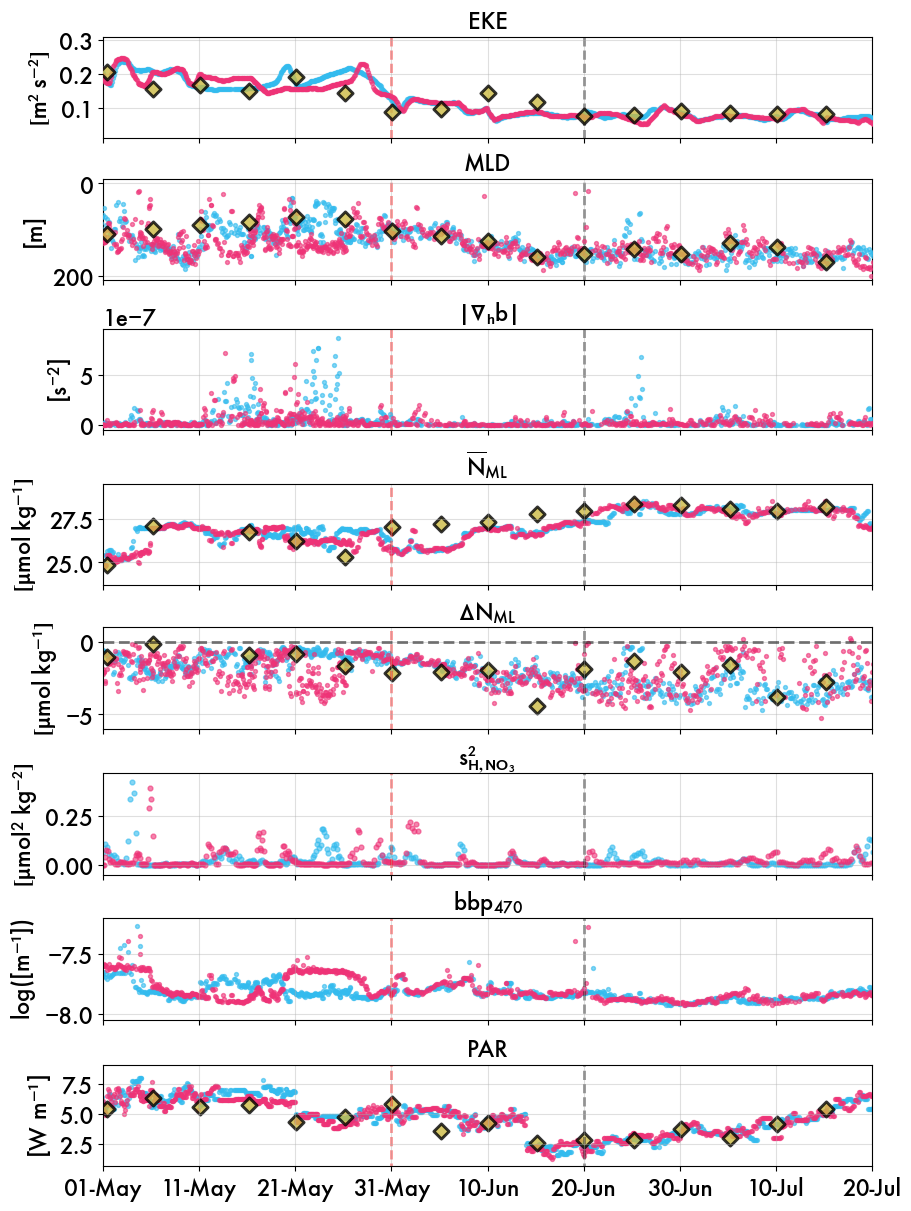

In [1327]:
importlib.reload(mlv)
importlib.reload(sgplot)
# reload(sg)
# from mod_plot import *
sgplot.plt_time_series(fsize = (9,12), dotsize=8, diasize=60, titlesize=16, dateformat=True)

In [86]:
reload(sg)
reload(sgplot)

<module 'mod_plot' from '/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/RandomForest_SG/scripts/mod_plot.py'>

In [79]:
dav_659 = pd.read_csv('../data/glider/dav_659_EKEPAR.csv', index_col=0)  
dav_660 = pd.read_csv('../data/glider/dav_660_EKEPAR.csv')
dav_float = pd.read_csv('../data/bgc-argo/dav_sgfloat_EKEPAR.csv')

for var in ['eke', 'eke_avg']:
    dav_659[var] = dav_659[var]/2
    dav_660[var] = dav_660[var]/2
    dav_float[var] = dav_float[var]/2


In [84]:
vlist = ['profid', 'yearday', 'lat', 'lon', 'mld', 'eke', 'eke_avg', 'par']
dav_659[vlist]

profid     yearday        lat        lon         mld       eke  \
0    6590000  119.585031 -51.494618  30.048702         NaN  0.337256   
1    6590001  119.592706 -51.491504  30.054853         NaN  0.336052   
2    6590002  119.619936 -51.480539  30.077068  106.706000  0.331958   
3    6590003  119.631899 -51.475917  30.088078  108.472375  0.330315   
4    6590004  119.689304 -51.449310  30.141417   92.323833  0.314054   
..       ...         ...        ...        ...         ...       ...   
907  6590907  205.591044 -51.722662  38.912155  173.587000  0.063737   
908  6590908  205.704530 -51.719360  38.927557  177.120750  0.065028   
909  6590909  205.806132 -51.715944  38.949354  154.404400  0.066580   
910  6590910  205.921993 -51.710122  38.972913  150.366333  0.068600   
911  6590911  206.026239 -51.703824  38.989142  144.308667  0.070357   

      eke_avg       par  
0    0.217549  5.083996  
1    0.218243  5.083996  
2    0.220802  5.083996  
3    0.222178  5.665997  
4    0.224623  5.087997  
..        ...       ...  
907  0.083008  6.767998  
908  0.081539  6.499996  
909  0.079422  6.499996  
910  0.077173  6.303997  
911  0.075665  6.511997  

[912 rows x 8 columns]

In [85]:
# dav_659[vlist].to_csv('../data/glider/dav_659_EKEPAR.csv') 
# dav_660[vlist].to_csv('../data/glider/dav_660_EKEPAR.csv')
# dav_float[vlist].to_csv('../data/bgc-argo/dav_sgfloat_EKEPAR.csv')

In [76]:
dav_659['eke'] = dav_660['eke']/2

# CWT WAVELET PLOTS

In [24]:
d0_660 = {27.3: 174.62, 27.4: 223.69, 27.5: 296.81, 27.6: 396.96}

In [22]:
# Best way to rerun
dir = '../working-vars/ML-wavelet/'
d0_660 = {27.3: 174.62, 27.4: 223.69, 27.5: 296.81, 27.6: 396.96}
nitscal_xtime = pd.read_csv(dir + 'nitscal660_xtime.csv', index_col=0)
nitscal_freq = pd.read_csv(dir + 'nitscal660_freq.csv', index_col=0)
nitscal_coi = pd.read_csv(dir + 'nitscal660_coi.csv', index_col=0)

nit_zamp = {k:v for k,v in zip([27.3, 27.4, 27.5, 27.6], np.tile(None, 4))}
nit_sigamp = {k:v for k,v in zip([27.3, 27.4, 27.5, 27.6], np.tile(None, 4))}
for sig in [27.3, 27.4, 27.5, 27.6]:
    nit_zamp[sig] = pd.read_csv(dir + 'nitscal660_zamp_' + str(int(sig*10)) + '.csv', index_col=0).values
    nit_sigamp[sig] = pd.read_csv(dir + 'nitscal660_signif_amp_' + str(int(sig*10)) + '.csv', index_col=0).values

# same for spice scalograms
spiscal_xtime = pd.read_csv(dir + 'spiscal660_xtime.csv', index_col=0)
spiscal_freq = pd.read_csv(dir + 'spiscal660_freq.csv', index_col=0)
spiscal_coi = pd.read_csv(dir + 'spiscal660_coi.csv', index_col=0)

spi_zamp = {k:v for k,v in zip([27.3, 27.4, 27.5, 27.6], np.tile(None, 4))}
spi_sigamp = {k:v for k,v in zip([27.3, 27.4, 27.5, 27.6], np.tile(None, 4))}
for sig in [27.3, 27.4, 27.5, 27.6]:
    spi_zamp[sig] = pd.read_csv(dir + 'spiscal660_zamp_' + str(int(sig*10)) + '.csv', index_col=0).values
    spi_sigamp[sig] = pd.read_csv(dir + 'spiscal660_signif_amp_' + str(int(sig*10)) + '.csv', index_col=0).values



In [28]:
reload(sgplot)

<module 'mod_plot' from '/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/RandomForest_SG/scripts/mod_plot.py'>

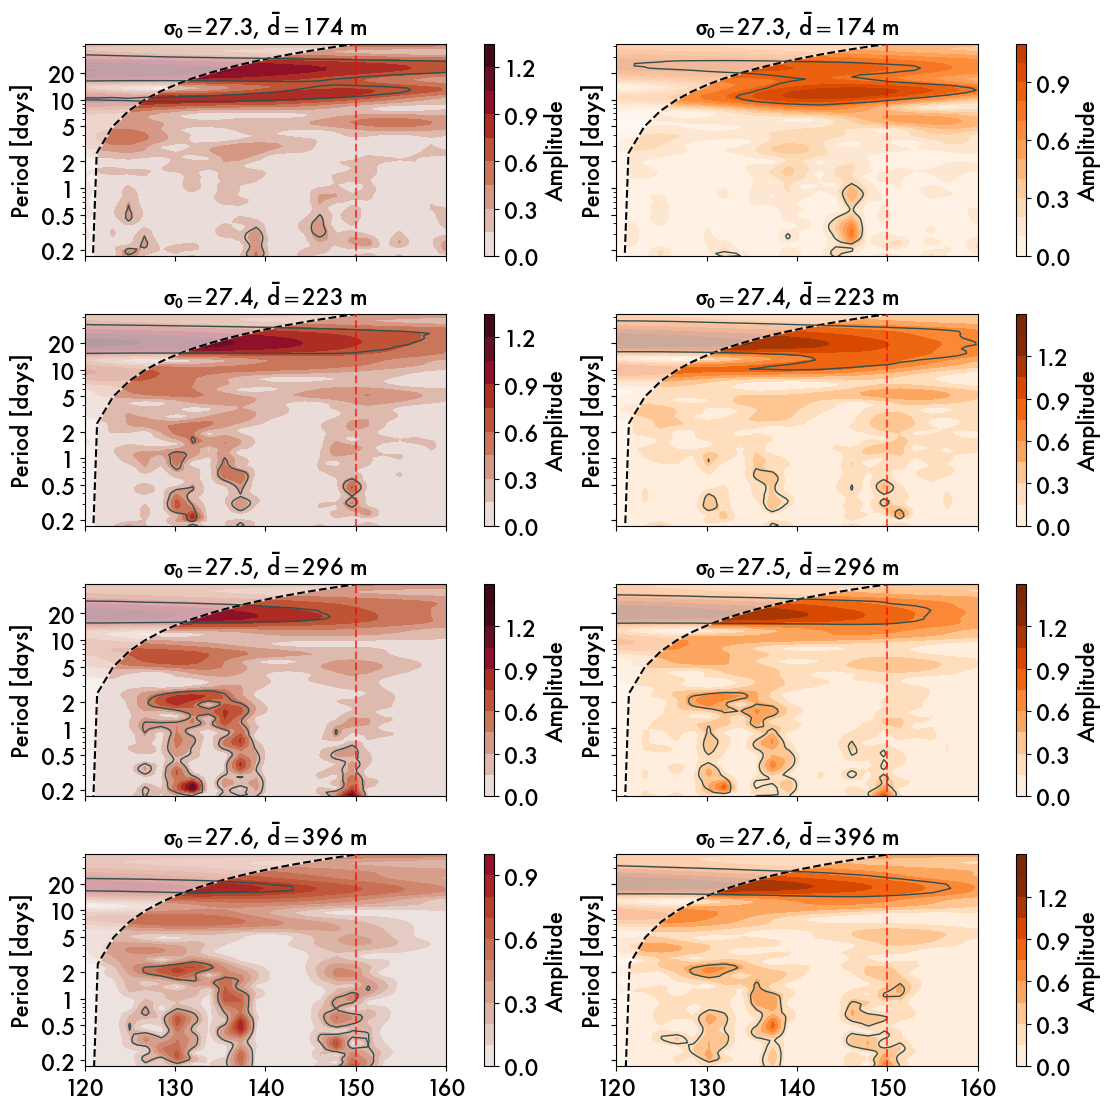

In [29]:
# ADAPTED FOR FULL PAPER FIG: 
fig, axs = plt.subplots(4, 2, figsize=(11,11), sharex=True, sharey=True, layout='constrained')

# Adapted from Pyleoclim
for ind, sig in enumerate([27.3, 27.4, 27.5, 27.6]):
    frequency = nitscal_freq[str(sig)].dropna().values
    xtime = nitscal_xtime[str(sig)]
    coi = nitscal_coi[str(sig)]
    zamp = nit_zamp[sig]
    signif_amp = nit_sigamp[sig]
    contourf_args={'cmap':cmo.amp, 'vmax': 1.3, 'origin': 'lower', 'levels': 11}

    sgplot.plot_cwt(sig, frequency, xtime, coi, zamp, signif_amp, ax=axs[ind,0], cmap=cmo.amp)
    
for ind, sig in enumerate([27.3, 27.4, 27.5, 27.6]):
    frequency = spiscal_freq[str(sig)].dropna().values
    xtime = spiscal_xtime[str(sig)]
    coi = spiscal_coi[str(sig)]
    zamp = spi_zamp[sig]
    signif_amp = spi_sigamp[sig]
    contourf_args={'cmap':'Oranges', 'vmax': 1.3, 'origin': 'lower', 'levels': 11}

    sgplot.plot_cwt(sig, frequency, xtime, coi, zamp, signif_amp, ax=axs[ind,1], cmap='Oranges', dateformat=False)

for ax in axs.flatten():
    ax.set_xlim([120,160])

# xt = [120, 140, 160, 180, 200]
# dateformat=False
# for ax in axs.flatten():
#     ax.vlines(150, 0,50, color='r', linewidth=1.5, linestyle='dashed', alpha=0.65, zorder=3)
#     ax.vlines(170, 0,50, color='k', linewidth=1.5, linestyle='dashed', alpha=0.65, zorder=3)

#     ax.set_yticks(yticks)
#     ax.set_yticklabels(['0.2', '0.5', '1', '2', '5', '10', '20'])

#     if dateformat: 
#         for ax in axs[3,0:2]:
#             ax.set_xticks(xt)
#             ax.set_xticklabels(['1-May', '21-May', '10-Jun', '30-Jun', '20-Jul'])

# for ax in axs[0:4,1]:
#     ax.set_


In [31]:
# sgplot.isos
isosignal_660 = {k:v for k,v in zip(sgplot.isos, np.tile(None, 4))}
dir = '../working-vars/ML-wavelet/'
for sig in [27.3, 27.4, 27.5, 27.6]: 
    isosignal_660[sig] = pd.read_csv(dir + 'isosignal660_' + str(int(sig*10)) + '.csv', index_col=0)


In [34]:
for sig in sgplot.isos:
    nit_zamp[sig] = pd.read_csv(dir + 'nitscal660_zamp_' + str(int(sig*10)) + '.csv', index_col=0).values
    nit_sigamp[sig] = pd.read_csv(dir + 'nitscal660_signif_amp_' + str(int(sig*10)) + '.csv', index_col=0).values


In [294]:
xt = [120, 130, 140, 150, 160]
[sg.ytd2datetime(k) for k in xt]

[numpy.datetime64('2019-05-01'),
 numpy.datetime64('2019-05-11'),
 numpy.datetime64('2019-05-21'),
 numpy.datetime64('2019-05-31'),
 numpy.datetime64('2019-06-10')]

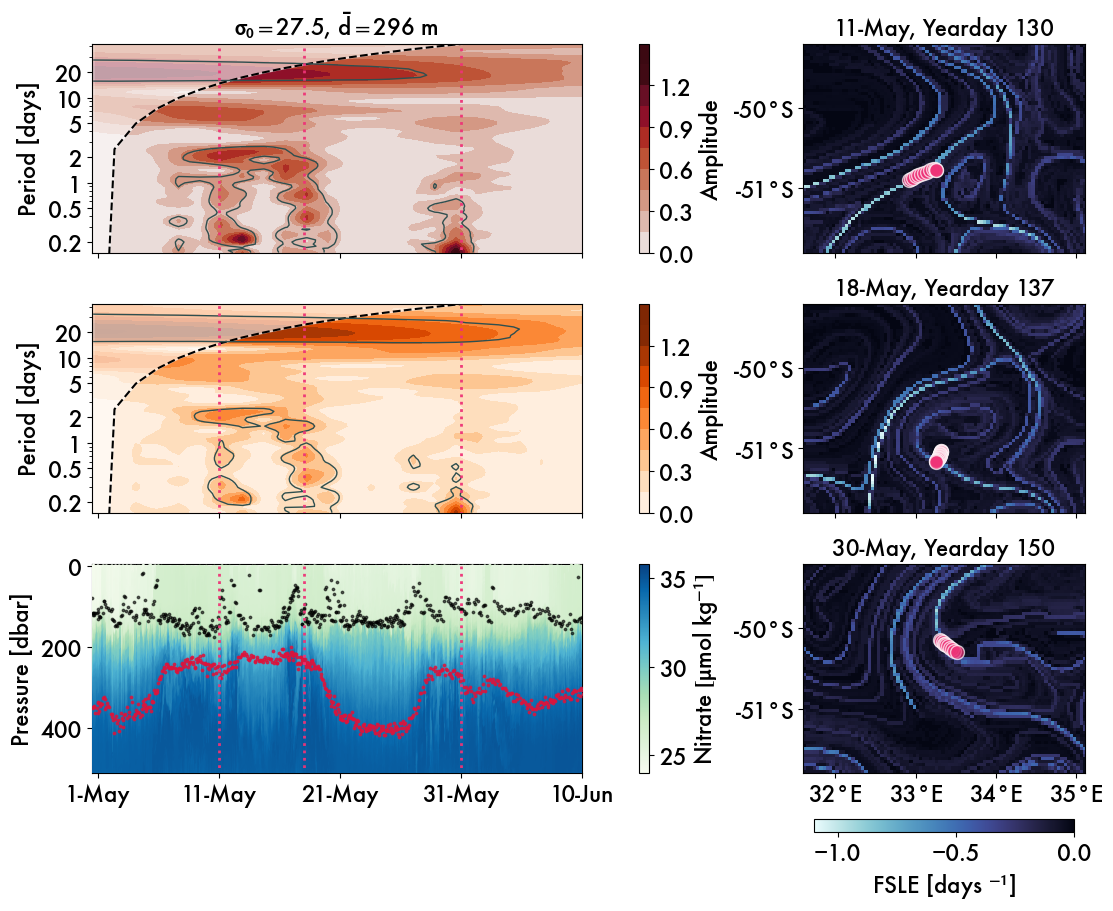

In [1425]:
# PAPER FIG: not yet in mod_plot
sig = 27.5
# fig, axs = plt.subplots(3, 1, figsize=(9,9), sharex=True, layout='constrained') # 10,12 no labels

fig, axs = plt.subplots(3, 2, figsize=(11,9), sharex='col', layout='constrained', width_ratios=[1.7,1]) # 10,12 no labels

importlib.reload(sgplot)

dateformat = True
xt = [120, 130, 140, 150, 160]
dft= ['1-May', '11-May', '21-May', '31-May', '10-Jun']

daylist = [130, 137, 150] # np.arange(131,138,1)
dayft= ['11-May', '18-May', '30-May']


for ax in axs[0:1,0]:
    frequency = nitscal_freq[str(sig)].dropna().values
    xtime = nitscal_xtime[str(sig)]
    coi = nitscal_coi[str(sig)]
    zamp = nit_zamp[sig]
    signif_amp = nit_sigamp[sig]
    contourf_args={'cmap':cmo.amp, 'vmax': 1.3, 'origin': 'lower', 'levels': 11}
    sgplot.plot_cwt(sig, frequency, xtime, coi, zamp, signif_amp, ax=ax, cmap=cmo.amp, ekeline=False)
    for day in daylist:
        ax.vlines(day, 0,50, color=plat_colors['sg660'], linewidth=2, linestyle='dotted', alpha=0.95, zorder=3)

for ax in axs[1:2,0]:
    frequency = spiscal_freq[str(sig)].dropna().values
    xtime = spiscal_xtime[str(sig)]
    coi = spiscal_coi[str(sig)]
    zamp = spi_zamp[sig]
    signif_amp = spi_sigamp[sig]
    sgplot.plot_cwt(sig, frequency, xtime, coi, zamp, signif_amp, ax=ax, cmap='Oranges', ekeline=False)
    for day in daylist:
        ax.vlines(day, 0,50, color=plat_colors['sg660'], linewidth=2, linestyle='dotted', alpha=0.95, zorder=3)

# Plot nitrate section
for ax in axs[2:3,0]:
    ylim=510
    df_glid = df_660[df_660.pressure<ylim]
    sca = ax.scatter(df_glid.yearday, df_glid.pressure,c=df_glid.nitrate_G, cmap='GnBu', s=3, zorder=3, vmin=24.0, vmax=35.8)

    # isopycnal
    for sigma in [sig]:
        ax.scatter(isosignal_660[sigma].yearday, isosignal_660[sigma].pressure, c = 'crimson', s=3, label=sigma, alpha=0.8, zorder=3)
    ax.set_ylabel('Pressure [dbar]')
    plt.colorbar(sca).set_label('Nitrate ' + sgplot.umol_unit)

    # MLD
    ax.scatter(dav_660.yearday, dav_660.mld, s=3, c='k', alpha=0.6, zorder=3)
    ax.invert_yaxis()
    ylims = [ylim,-5]
    ax.set_ylim(ylims)

    # Vertical Lines
    for day in daylist:
        ax.vlines(day, 0,500, color=plat_colors['sg660'], linewidth=2, linestyle='dotted', alpha=0.95, zorder=3)


# Set x limits and titles
for ax in axs.flatten():
    ax.set_xlim([119.5, 160])
    ax.set_title('')
for ax in axs[0,0:1]:
    ax.set_title(r'$\mathbf{\sigma_0}=$' + str(sig) + ', ' + r'$\mathregular{\bar{d}}=$' + str(int(d0_660[sig])) + ' m',
                        fontsize=16)
if dateformat: 
    for ax in axs[:,0]:
        ax.set_xticks(xt)
        ax.set_xticklabels(dft)


# Plot right hand ADT altimetry 
altimetry = xr.open_dataset('../data/satellite/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1714604183615.nc')
FSLE = xr.open_dataset('../data/satellite/FSLE_sogos.nc')


for ind, day in enumerate(daylist):

    # if using ALTIMETRY ADT
    # altimetry.adt.attrs={'long_name':'ADT [m]'}
    # dat = altimetry.sel(time=sg.ytd2datetime(day), method='nearest')
    # map = dat.adt.plot(cmap=cmo.ice_r, ax=axs[ind,1], vmin=-1.1, vmax=+.01, zorder=1, add_colorbar=False)

    # if using FLSE 
    FSLE.fsle_max.attrs={'long_name':('FSLE ' + fsle_unit)}
    dat = FSLE.sel(time=sg.ytd2datetime(day), method='nearest')
    map = dat.fsle_max.plot(cmap=cmo.ice_r, ax=axs[ind,1], vmin=-1.1, vmax=-0.0, zorder=1, add_colorbar=False)

    axs[ind,1].set_title(dayft[ind] + ', Yearday ' + str(day), fontsize=16)

    # # Plot traj and points of glider on that day
    # axs[ind,1].plot(dav_660.lon, dav_660.lat, linewidth=2, linestyle='dashed', color=sgplot.plat_colors['sg660'], alpha=0.6)
    i = np.where(dav_660.yearday.round()==day)
    axs[ind,1].scatter(dav_660.lon.iloc[i], dav_660.lat.iloc[i], 100, color=plat_colors['sg660'], label = '660', zorder=3, alpha=0.7, edgecolors='w')

for ax in axs[:,1]:
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_ylim([-51.8, -49.2])
    ax.set_xlim([31.6, 35.1])  #39.1
    ax.set_aspect('equal')

    # ax.set_ylim([-54.7, -47.7])
    # ax.set_xlim([28.1, 38.1])  #39.1
    # ax.set_aspect('equal')
    ax.yaxis.set_major_formatter("{x:1.0f}°S")
    ax.xaxis.set_major_formatter("{x:1.0f}°E")


# plt.colorbar(map, orientation='horizontal', ax=axs[2,1], shrink=0.6).set_label('ADT [m]')
plt.colorbar(map, orientation='horizontal', ax=axs[2,1], shrink=0.9).set_label('FSLE ' + fsle_unit)


In [1360]:

file_path = '/Users/sangminsong/OneDrive - UW/Code/SOGOS/'
filename="data/FSLE_sogos.nc"
FSLE = xr.open_dataset(file_path + filename)


FSLE.fsle_max.attrs={'long_name':('FSLE ' + fsle_unit)}

dat = FSLE.sel(time=sg.ytd2datetime(day), method='nearest')
map = dat.fsle_max.plot(cmap=cmo.ice_r, ax=axs[ind], vmin=-1.2, vmax=0, zorder=1, add_colorbar=False)
plt.colorbar(map, ax=axs[ind], orientation='horizontal', shrink=0.5).set_label('ADT [m]')


In [1427]:
altimetry


<xarray.Dataset>
Dimensions:         (time: 87, latitude: 64, longitude: 96)
Coordinates:
  * latitude        (latitude) float32 -57.88 -57.62 -57.38 ... -42.38 -42.12
  * longitude       (longitude) float32 18.12 18.38 18.62 ... 41.38 41.62 41.88
  * time            (time) datetime64[ns] 2019-04-30 2019-05-01 ... 2019-07-25
Data variables:
    adt             (time, latitude, longitude) float32 ...
    err_sla         (time, latitude, longitude) float32 ...
    err_ugosa       (time, latitude, longitude) float32 ...
    err_vgosa       (time, latitude, longitude) float32 ...
    flag_ice        (time, latitude, longitude) float32 ...
    sla             (time, latitude, longitude) float32 ...
    tpa_correction  (time) float32 ...
    ugos            (time, latitude, longitude) float32 ...
    ugosa           (time, latitude, longitude) float32 ...
    vgos            (time, latitude, longitude) float32 ...
    vgosa           (time, latitude, longitude) float32 ...
Attributes:
    Conventions:       CF-1.11
    title:             DT merged all satellites Global Ocean Gridded SSALTO/D...
    institution:       CLS, CNES
    source:            Altimetry measurements
    history:           2021-07-26 19:51:56Z: Creation
    contact:           servicedesk.cmems@mercator-ocean.eu
    references:        http://marine.copernicus.eu
    comment:           Sea Surface Height measured by Altimetry and derived v...
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  SEALEVEL_GLO_PHY_L4_MY_008_047
    subset:datasetId:  cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1...
    subset:date:       2024-05-01T22:56:23.620Z

In [1426]:
FSLE

<xarray.Dataset>
Dimensions:    (lat: 150, lon: 300, time: 88)
Coordinates:
  * lat        (lat) float32 -54.86 -54.82 -54.78 -54.74 ... -48.98 -48.94 -48.9
  * lon        (lon) float32 28.14 28.18 28.22 28.26 ... 39.98 40.02 40.06 40.1
  * time       (time) datetime64[ns] 2019-04-29 2019-04-30 ... 2019-07-25
Data variables:
    fsle_max   (time, lat, lon) float32 ...
    theta_max  (time, lat, lon) float32 ...
Attributes: (12/27)
    cdm_data_type:              Grid
    Conventions:                CF-1.6
    standard_name_vocabulary:   http://cf-pcmdi.llnl.gov/documents/cf-standar...
    title:                      Backward-in-time, finite-size Lyapunov expone...
    summary:                    This dataset contains Backward-in-time FSLE p...
    separation:                 Initial separation in degrees: 0.02; Maximal ...
    ...                         ...
    project:                    SSALTO/DUACS
    references:                 www.aviso.altimetry.fr
    end_time:                   2019-03-28 00:00:00
    start_time:                 2019-10-14 00:00:00
    time_coverage_resolution:   P4D
    EXTRA_DIMENSION.nv:         2

In [240]:
altimetry = xr.open_dataset('../data/satellite/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1714604183615.nc')

[Text(0, 0.2, '0.2'),
 Text(0, 0.5, '0.5'),
 Text(0, 1.0, '1.0'),
 Text(0, 2.0, '2.0'),
 Text(0, 5.0, '5.0'),
 Text(0, 10.0, '10.0'),
 Text(0, 20.0, '20.0')]

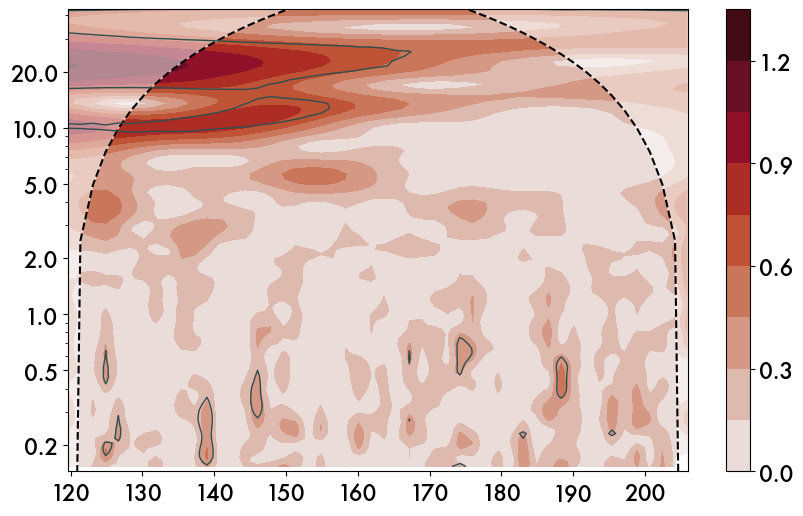

In [176]:
# ADAPT THE PYLEOCLIM METHOD

# 1-D 
sig = '27.3'
frequency = nitscal_freq[sig].dropna().values
xtime = nitscal_xtime[sig]
coi = nitscal_coi[sig]

# 2-D
sig = 27.3
zamp = nit_zamp[sig]
signif_amp = nit_sigamp[sig]

#### 
figsize = (10,6)
contourf_args={'cmap':cmo.amp, 'vmax': 1.3, 'origin': 'lower', 'levels': 11}


## Make fig
fig, ax = plt.subplots(figsize=figsize)
y_axis = 1/frequency
ylabel = 'Period [days]'
yticks_default = np.array([0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 1e4, 2e4, 5e4, 1e5, 2e5, 5e5, 1e6])
mask = (yticks_default >= np.min(y_axis)) & (yticks_default <= np.max(y_axis))
yticks = yticks_default[mask]


cont = ax.contourf(xtime,y_axis, zamp, **contourf_args)
ax.set_yscale('log')

cbar_args = {'drawedges': False, 'orientation': 'vertical', 'fraction': 0.15, 'pad': 0.05}
cbar_style={'label':'', 'ticks':[0.0, 0.3, 0.6, 0.9, 1.2]}
cbar_args.update(cbar_style)
cb = plt.colorbar(cont, **cbar_args)

# plot coi 
ax.plot(xtime, coi, 'k--')
ax.fill_between(xtime, coi, np.max(coi), color='white', alpha=0.5)

# plot significance levels
signif_clr='darkslategray'; signif_linestyles='-'; signif_linewidths=1
signif_method_label = {'ar1': 'AR(1)'}
signif_boundary = zamp / signif_amp
ax.contour(
    xtime, y_axis, signif_boundary, [-99, 1],
    colors=signif_clr,
    linestyles=signif_linestyles,
    linewidths=signif_linewidths,
)

ylim = [np.min(y_axis), np.min([np.max(y_axis), np.max(coi)])]
ax.set_ylim(ylim)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)



In [ ]:
# OLD PAPER FIG: Five nitrate CWTS
fig, axs = plt.subplots(4, 2, figsize=(16,16), sharex=True, sharey=True, layout='constrained')

for ind, sigma in enumerate([27.3, 27.4, 27.5]):
    cwt = nitrate_scal_signif_660[sigma]

    y_axis = 1/cwtdat_freq
    


    cwt.plot(ax=axs[ind, 0], title='', contourf_style={'cmap':cmo.amp, 'vmax':1.3}, signif_clr='darkslategray', signif_linestyles='-', signif_linewidths=1,
             cbar_style={'label':'', 'ticks':[0.0, 0.3, 0.6, 0.9, 1.2]})
    
    ax.
    axs[ind,0].set_title(r'$\sigma_0$' + ' = ' + str(sigma) + ', ' + r'$\mathregular{\bar{d}}$' + ' = ' + str(int(d0_660[sigma])) + 'm')
    # axs[ind,0].set_title('')
    axs[ind,0].set_xlabel('')
    axs[ind,0].set_ylabel('')

    axs[ind,0].vlines(150, 0,50, color='r', linewidth=2.5, linestyle='dashed', alpha=0.65, zorder=3)
    axs[ind,0].vlines(170, 0,50, color='k', linewidth=2.5, linestyle='dashed', alpha=0.65, zorder=3)

for sigma in [27.6]:
    ind=3
    cwt = nitrate_scal_signif_660[sigma]
    cwt.plot(ax=axs[ind, 0], title='', contourf_style={'cmap':cmo.amp, 'vmax':1.3}, signif_clr='darkslategray', signif_linestyles='-', signif_linewidths=1,
             cbar_style={'label':'', 'ticks':[0.0, 0.2, 0.4, 0.6, 0.8]})
    axs[ind,0].set_title(r'$\sigma_0$' + ' = ' + str(sigma) + ', ' + r'$\mathregular{\bar{d}}$' + ' = ' + str(int(d0_660[sigma])) + 'm')
    # axs[ind,0].set_title('')
    axs[ind,0].set_xlabel('')
    axs[ind,0].set_ylabel('')

    axs[ind,0].vlines(150, 0,50, color='r', linewidth=2.5, linestyle='dashed', alpha=0.65, zorder=3)
    axs[ind,0].vlines(170, 0,50, color='k', linewidth=2.5, linestyle='dashed', alpha=0.65, zorder=3)
# r"$\bf{" + r'$\sigma$' + "}$"


for ind, sigma in enumerate([27.3, 27.4, 27.5, 27.6]):
    cwt = spice_scal_signif_660[sigma]
    cwt.plot(ax=axs[ind, 1], title='', contourf_style={'cmap':'Oranges', 'vmax':1.4}, signif_clr='darkslategray', signif_linestyles='-', signif_linewidths=1,
             cbar_style={'label':''})
    axs[ind,1].set_title(r'$\sigma_0$' + ' = ' + str(sigma) + ', ' + r'$\mathregular{\bar{d}}$' + ' = ' + str(int(d0_660[sigma])) + 'm')
    # axs[ind,1].set_title(r'\textbf{A}\boldmath$_\sigma$' + ' = ' + str(sigma) + ', ' + r'$\mathregular{\bar{d}}$' + ' = ' + str(int(d0_660[sigma])) + 'm')
    # axs[ind,1].set_title('')
    axs[ind,1].set_xlabel('')
    axs[ind,1].set_ylabel('')

    axs[ind,1].vlines(150, 0,50, color='r', linewidth=2.5, linestyle='dashed', alpha=0.65, zorder=3)
    axs[ind,1].vlines(170, 0,50, color='k', linewidth=2.5, linestyle='dashed', alpha=0.65, zorder=3)

for r in [0]:
    axs[r,0].set_ylabel('Period [days]')
for r in [1]:
    axs[3,r].set_xlabel('Yearday')


In [ ]:
# 3 subplots CWTS: spice, nitrate, nitrate section

days_mark = [130.5, 137, 149.5, 176, 180, 189]

# fig, axs = plt.subplots(3, 1, figsize=(12,14), sharex=True, layout='constrained') # 10,12 no labels
fig, axs = plt.subplots(3, 2, figsize=(11,11), sharex=True, layout='constrained') # 10,12 no labels
axs=axs.flatten()
sigma = 27.4

# plot CWT

nitrate_scal_signif_660[sigma].plot(ax=axs[0], title='', contourf_style={'cmap':cmo.amp, 'vmax':1.4},
            signif_clr='darkslategray', signif_linestyles='-', signif_linewidths=1.5, cbar_style={'label':'Amplitude', 'ticks':[0.0, 0.3, 0.6, 0.9, 1.2, 1.5]})


tag = 'CWT, ' + r'$\sigma$' + ' = ' + str(sigma) + ', d = ' + str(int(d0_660[sigma])) + 'm'
spice_scal_signif_660[sigma].plot(ax=axs[1], title='', contourf_style={'cmap':'Oranges', 'vmax':1.3},  # biology: algae for AOU/AOU (oxyAOU)
            signif_clr='darkslategray', signif_linestyles='-', signif_linewidths=1.5, cbar_style={'label':'Amplitude', 'ticks':[0.0, 0.3, 0.6, 0.9, 1.2]})

for ax in axs[:2]:
    ax.set_title(tag)
    ax.hlines(0.643, 120, 205, color='w', linestyles='dashed', alpha=0.8, label='inertial period', zorder=3)
    ax.set_ylabel('')
    ax.set_xlabel('')
    # ax.set_ylim([0,20])
# axs[0].set_title('spice ' + tag)
# axs[1].set_title('nitrate ' + tag)

# Plot nitrate section
df_glid = df_660[df_660.pressure<420]
sca = axs[2].scatter(df_glid.yearday, df_glid.pressure,c=df_glid.nitrate, cmap='GnBu', s=8, zorder=3)
for sigma in [27.4]:
    axs[2].scatter(isosignal_660[sigma].yearday, isosignal_660[sigma].pressure, c = 'r', s=8, label=sigma, alpha=0.8, zorder=3)


axs[2].scatter(dav_660.yearday, dav_660.mld, s=8, c='k', alpha=0.6, zorder=3)
axs[2].invert_yaxis()
ylims = [420,-5]
axs[2].set_ylim(ylims)
# axs[2].set_title('')

for ax in axs:
    ax.set_xlim([119.5, 160])
    ax.set_title('')

plt.colorbar(sca).set_label('Nitrate')

axs[2].set_xlabel('Yearday')
axs[0].set_ylabel('Period [days]')
axs[1].set_ylabel('Period [days]')
axs[2].set_ylabel('Pressure [dbar]')




In [1414]:
file_path = '../data/satellite/FSLE_sogos.nc' # dataset-duacs-dt-global-allsat-madt-fsle_1645482413922.nc'
FSLE = xr.open_dataset(file_path)

In [ ]:
# def get_depth_bx(df_plat, dav_plat, d0=100, thresh=10):
#     rho0 = 1027 # reference density
#     buoyancy = lambda sigma0: -9.81 * (1 - ((sigma0 + 1000)/rho0) )
#     df_plat['B'] = buoyancy(df_plat.sigma0)

#     # create df of rows at 100m with valid buoyancy values
#     depth_bx = pd.DataFrame()
#     for ind, prof in enumerate(sg.list_profile_DFs(df_plat)):

#         # try changing this d0 to within the mixed layer 
#         d0 = dav_plat[ind].mld + 30

#     filtered_df = df[(df['distance'] >= (d0 - thresh)) & (df['distance'] <= (d0 + thresh))]
#     if len(filtered_df)>0:
#     # Find the row with the closest value of "distance" to 100
#         closest_row = filtered_df.iloc[(filtered_df['distance'] - d0).abs().idxmin()]
#         depth_bx = pd.concat([depth_bx, closest_row], axis=1, ignore_index=True)

#     depth_bx = depth_bx.T

#     #     temp = prof[prof.pressure<d0]
#     #     # if there are observations close to 100
#     #     if len(temp)>0:
#     #         row = temp.iloc[-1].copy() # deepest row under 100m
#     #         if row.pressure > (d0-thresh): # only add if deeper than 90m
#     #             depth_bx = pd.concat([depth_bx, row], axis=1, ignore_index=True)
#     # depth_bx = depth_bx.T


#     # Find distance between profiles which we know the buoyancies for
#     depth_bx['xdist'] = np.tile(0, len(depth_bx))
#     depth_bx.loc[1:, 'xdist'] = dist_between_profiles(depth_bx)

#     # Now take difference in B between successive profiles
#     depth_bx['Bx'] = np.tile(np.nan, len(depth_bx))
#     for i in np.arange(1, len(depth_bx), 1):
#         B1 = depth_bx.B[i-1]
#         B2 = depth_bx.B[i]
#         diff = np.abs(B2-B1)
#         dist = depth_bx.xdist[i]
#         depth_bx.at[i, 'Bx'] = diff/dist

#     return depth_bx


In [ ]:
d0 = 30
thresh = 5

bx30_659 = get_ml_bx(df_659, dav_659, d0=d0, thresh=thresh)
bx30_660 = get_ml_bx(df_660, dav_660, d0=d0, thresh=thresh)

/var/folders/nt/sjynqxjj7cz9r15fkd5d4r_40000gn/T/ipykernel_3609/2187062654.py:28: RuntimeWarning: Mean of empty slice
  rho = np.nanmean(upperprof.sigma0) + 1000


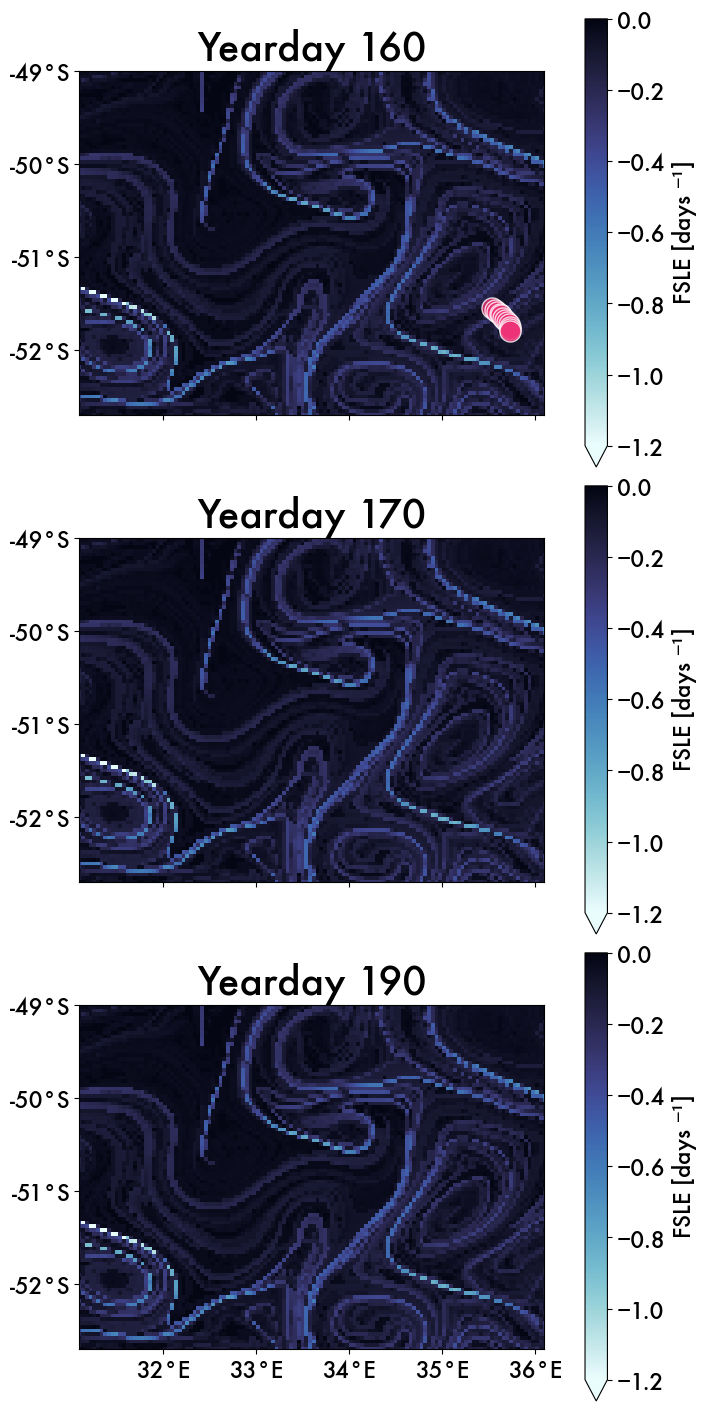

In [1410]:
# TRY WITH FSLE
savefig = False
# savefig = True

hue659 = plat_colors['sg659']
hue660 = plat_colors['sg660']

fsle_unit =  ('[days ' + r'$\mathbf{^{-1}}$' + ']')
# fig = plt.figure(figsize=(9,6))
fig, axs = plt.subplots(3,1, figsize=(7,14), layout='constrained', sharex=True)
axs = axs.flatten()

daylist = [131, 137, 150] # np.arange(131,138,1)
daylist = [160, 170, 190] # np.arange(131,138,1)

for ind, day in enumerate(daylist):
    
    FSLE.fsle_max.attrs={'long_name':('FSLE ' + fsle_unit)}
    
    dat = FSLE.sel(time=sg.ytd2datetime(day), method='nearest')
    map = dat.fsle_max.plot(cmap=cmo.ice_r, ax=axs[ind], vmin=-1.2, vmax=0, zorder=1, add_colorbar=True)
    # plt.colorbar(map, ax=axs[ind], orientation='horizontal', shrink=0.5).set_label('ADT [m]')

    axs[ind].set_title('Yearday ' + str(day), fontsize=28)

    # axs[ind].plot(dav_660.lon, dav_660.lat, linewidth=4, linestyle='dashed', color=hue660, alpha=0.5)
    # # Plot points of glider on that day
    i = np.where(dav_660.yearday.round()==day)
    axs[ind].scatter(dav_660.lon.iloc[i], dav_660.lat.iloc[i], 230, color=hue660, label = '660', zorder=3, alpha=0.8, edgecolors='w')

for ax in axs:
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_ylim([-52.7, -49])
    ax.set_xlim([31.1, 36.1])  #39.1
    ax.set_aspect('equal')
    ax.yaxis.set_major_formatter("{x:1.0f}°S")
    ax.xaxis.set_major_formatter("{x:1.0f}°E")



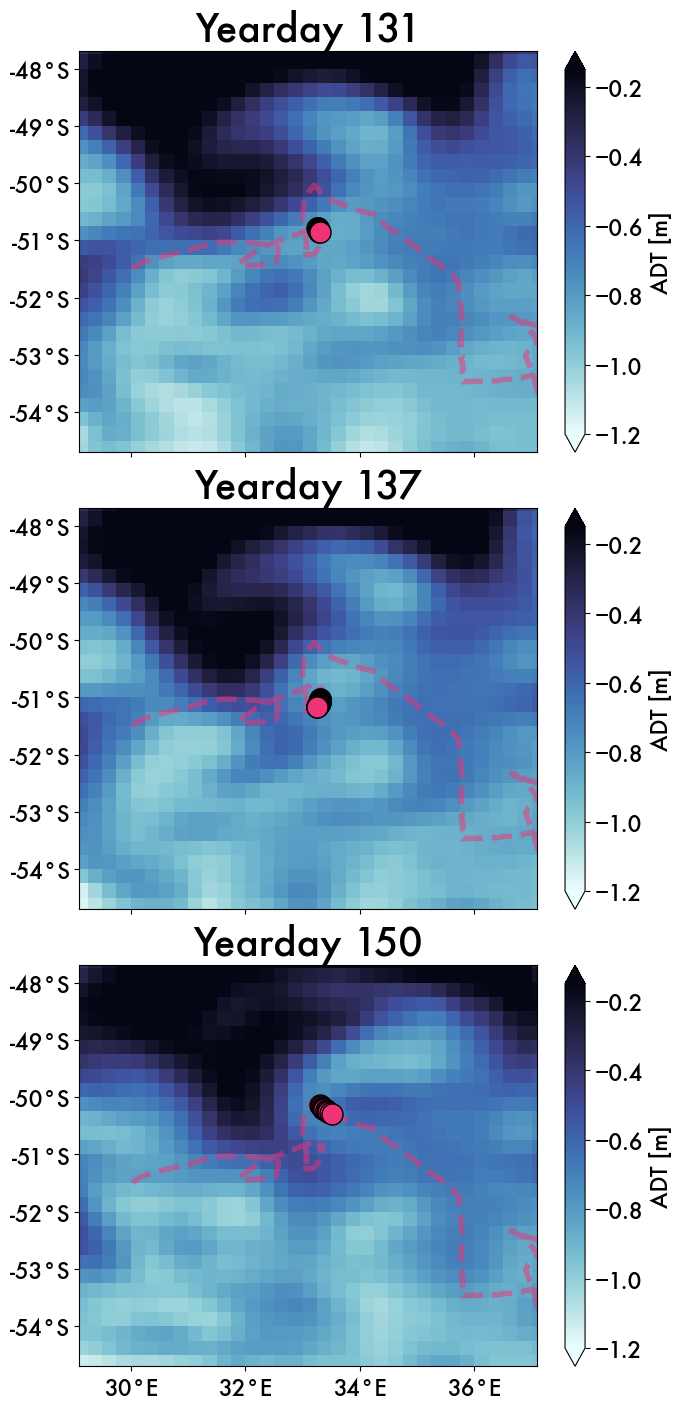

In [37]:
# PAPER FIG: PLOTS OF WHERE CWT ARE HIGH

file_path = '/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/SOGOS-ML/figures/'
fname = 'sg660_paths_labeled_yd'
savefig = False
# savefig = True

hue659 = plat_colors['sg659']
hue660 = plat_colors['sg660']

# fig = plt.figure(figsize=(9,6))
fig, axs = plt.subplots(3,1, figsize=(7,14), layout='constrained', sharex=True)
axs = axs.flatten()

daylist = [131, 137, 150] # np.arange(131,138,1)
for ind, day in enumerate(daylist):
    
    altimetry.adt.attrs={'long_name':'ADT [m]'}
    dat = altimetry.sel(time=sg.ytd2datetime(day), method='nearest')
    map = dat.adt.plot(cmap=cmo.ice_r, ax=axs[ind], vmin=-1.2, vmax=-.15, zorder=1)
    # plt.colorbar(map, ax=axs[ind], orientation='horizontal', shrink=0.5).set_label('ADT [m]')

    axs[ind].set_title('Yearday ' + str(day), fontsize=28)
    axs[ind].plot(dav_660.lon, dav_660.lat, linewidth=4, linestyle='dashed', color=hue660, alpha=0.5)

    # # Plot points of glider on that day
    i = np.where(dav_660.yearday.round()==day)
    axs[ind].scatter(dav_660.lon.iloc[i], dav_660.lat.iloc[i], 230, color=hue660, label = '660', zorder=3, alpha=1, edgecolors='k')

    # Plot nearest argo float location
    dayfloat = sgfloat[sgfloat.yearday==(day // 5) * 5]  # use floor function to round day to nearest 5 day, to match argo
    axs[ind].scatter(dayfloat.lon, dayfloat.lat, s=800, color='yellow', alpha=1, marker='D', edgecolors='k', label='argo', zorder=3)

for ax in axs:
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_ylim([-54.7, -47.7])
    ax.set_xlim([29.1, 37.1])  #39.1
    ax.set_aspect('equal')
    ax.yaxis.set_major_formatter("{x:1.0f}°S")
    ax.xaxis.set_major_formatter("{x:1.0f}°E")

In [1340]:
dav_glids = pd.concat([dav_659, dav_660])

np.min(dav_glids[dav_glids.yearday<150].eke_avg)

0.124054028389568

In [1341]:
np.max(dav_glids[dav_glids.yearday>170].eke_avg)

0.1085845070699287

# DISCUSSION

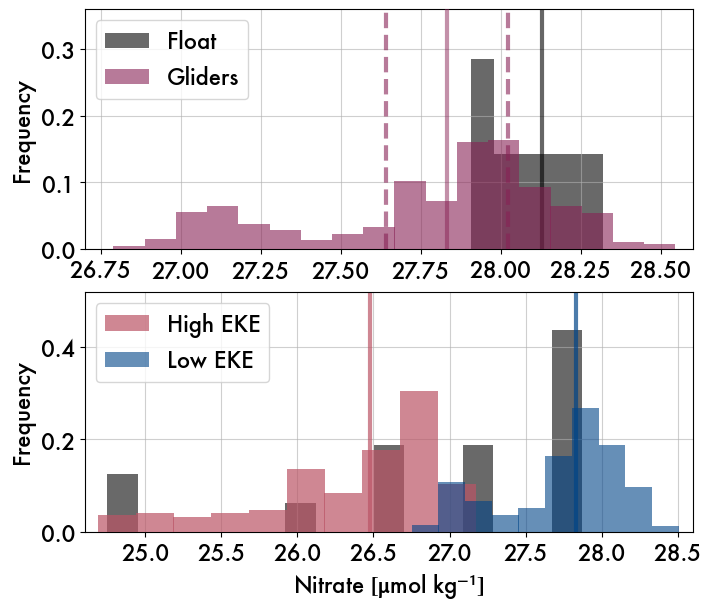

In [128]:
# PAPER fig comparison MEAN NITRATE ML
fig, axs = plt.subplots(2,1,figsize=(7,6), sharex=False, layout='constrained') # 14,12
axs = axs.flatten()

# First compare float vs gliders
ml_glids = pd.concat([mlstat_659, mlstat_660])
ml_glids = ml_glids[ml_glids.yearday>170]
flt = mlstat_float[mlstat_float.yearday>170]

ml_glids = ml_glids.nitrate_mean.dropna().values
flt = flt.nitrate_mean.dropna().values

# Plot comparison of platforms
for ax in axs[:1]:
    hist, bin_edges = np.histogram(flt, bins=6); freq = hist/np.sum(hist)
    ax.bar(bin_edges[:-1], freq, width = 0.069, color='dimgrey',alpha=1, label='Float', zorder=1)
    ax.vlines(flt.mean(), 0, 0.36, linestyle='-', alpha=0.6, linewidth=3, color='k', zorder=3)

    hist, bin_edges = np.histogram(ml_glids, bins=18); freq = hist/np.sum(hist)
    ax.bar(bin_edges[:-1], freq, width = 0.098, color='#882255',alpha=0.6, label='Gliders', zorder=3)
    ax.vlines(ml_glids.mean(), 0, 0.36, linestyle='-', alpha=0.5, linewidth=3, color='#882255', zorder=3)
    ax.vlines(ml_glids.mean() + 0.19, 0, 0.36, linestyle='--', alpha=0.6, linewidth=3, color='#882255', zorder=3)
    ax.vlines(ml_glids.mean() - 0.19, 0, 0.36, linestyle='--', alpha=0.6, linewidth=3, color='#882255', zorder=3)

    ax.set_ylim([0,0.36])
    ax.set_xlim([26.7, 28.6])
    ax.legend(loc='upper left', fontsize=16)

# Then compare high vs low EKE
ml_glids = pd.concat([mlstat_659, mlstat_660])
highEKE = ml_glids[ml_glids.yearday<150]
lowEKE = ml_glids[ml_glids.yearday>170]
highEKE = highEKE.dropna(subset=['nitrate_mean']).copy()
lowEKE = lowEKE.dropna(subset=['nitrate_mean']).copy()

hdat = highEKE.nitrate_mean.dropna()
ldat = lowEKE.nitrate_mean.dropna()
flt = mlstat_float.nitrate_mean.dropna()

for ax in axs[1:]:
    hist, bin_edges = np.histogram(flt, bins=6); freq = hist/np.sum(hist)
    ax.bar(bin_edges[:-1], freq, width = 0.2, alpha=1, facecolor = 'dimgrey', zorder=1)

    hist, bin_edges = np.histogram(hdat, bins=10); freq = hist/np.sum(hist)
    ax.bar(bin_edges[:-1], freq, width = 0.25, alpha=0.7, facecolor= eke_colors['high'], label='High EKE', zorder=3)

    hist, bin_edges = np.histogram(ldat, bins=10); freq = hist/np.sum(hist)
    ax.bar(bin_edges[:-1], freq, width = 0.176, alpha=0.6, facecolor = eke_colors['low'], label='Low EKE', zorder=3)

    ax.vlines(hdat.mean(), 0, 0.52, linestyle='-', alpha=0.7, linewidth=3, color=eke_colors['high'])
    ax.vlines(ldat.mean(), 0, 0.52, linestyle='-', alpha=0.7, linewidth=3, color=eke_colors['low'])
    ax.set_xlabel('Nitrate ' + umol_unit)
    ax.set_xlim([24.6, 28.6])
    ax.set_ylim([0, 0.52])
    # ax.set_title('Mean ML Nitrate between EKE regions', fontsize=16)
    ax.legend(loc='upper left', fontsize=16)

for ax in axs:
    ax.grid(zorder=0, alpha=0.6)
    ax.set_ylabel('Frequency')

# plt.savefig('../paper_figs/mlnitrate_1dhist.png', dpi=300)

# SUPPLEMENTARY

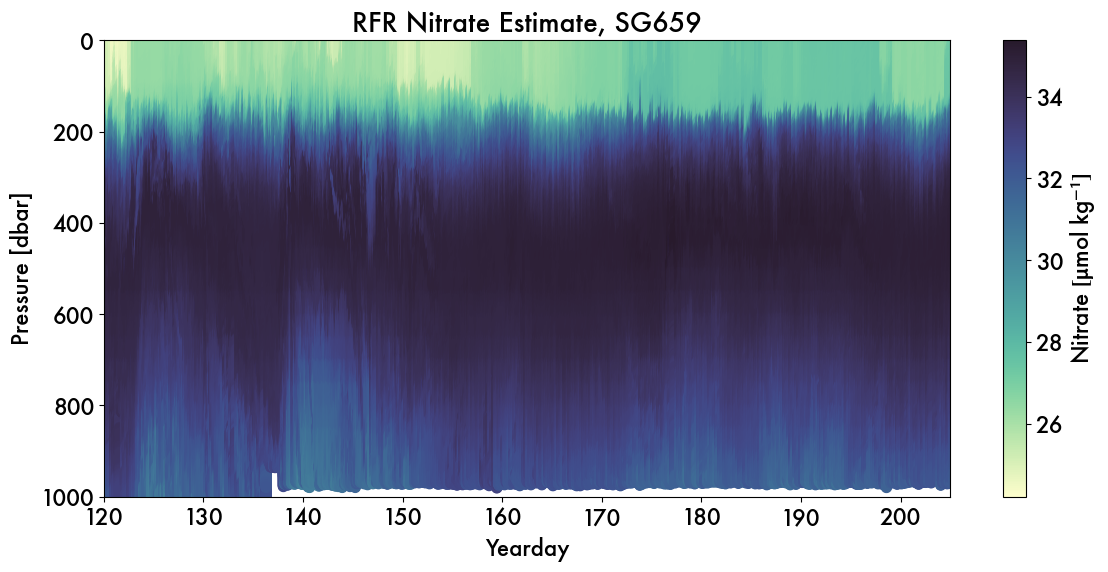

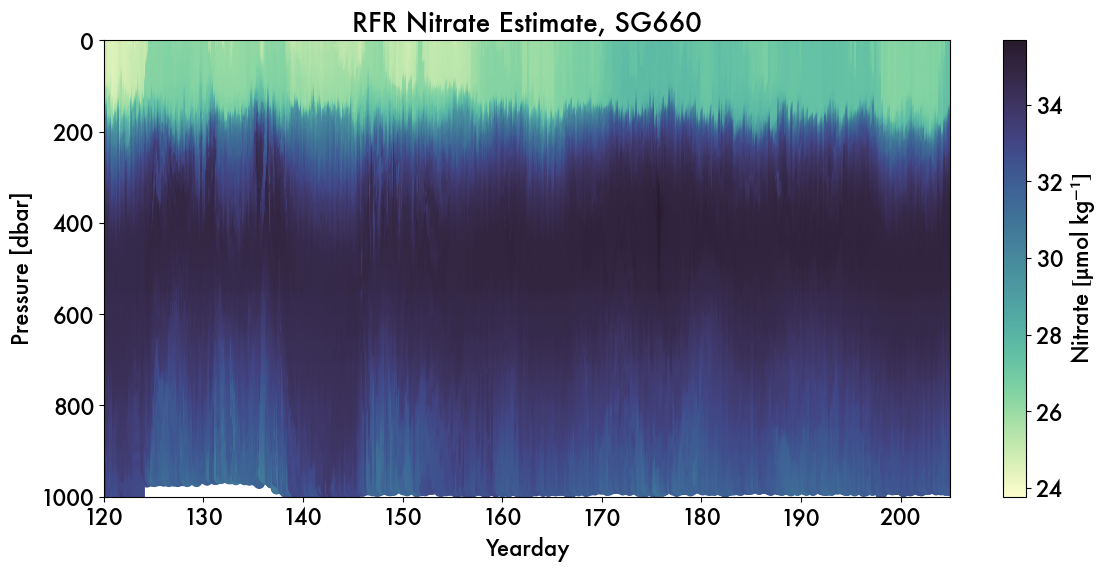

In [1430]:
# * Glider prediction nitrate profile

# dat = df_659[(df_659.yearday <maxday) & (df_659.yearday > minday)]
dat = df_659
tag = 'RFR Nitrate Estimate, SG659'


fig  = plt.figure(figsize=(12,6), tight_layout=True)
ax = plt.gca()
sca = ax.scatter(dat.yearday, dat.pressure, c=dat.nitrate_G, cmap=cmo.deep, s=50) #, vmin=1.5, vmax=3.6) #, marker='s')
ax.set_title(tag )

plt.colorbar(sca, ax=ax).set_label('Nitrate ' + umol_unit)

ax.invert_yaxis()
ax.set_ylabel('Pressure [dbar]')
ax.set_xlabel('Yearday')
ax.set_xlim([120, 205])
ax.set_ylim([1000,0])

plt.show()

# * Glider prediction nitrate profile


dat = df_660
tag = 'RFR Nitrate Estimate, SG660'

fig  = plt.figure(figsize=(12,6), tight_layout=True)
ax = plt.gca()
sca = ax.scatter(dat.yearday, dat.pressure, c=dat.nitrate_G, cmap=cmo.deep, s=50) #, vmin=1.5, vmax=3.6) #, marker='s')
ax.set_title(tag )

plt.colorbar(sca, ax=ax).set_label('Nitrate ' + umol_unit)

ax.invert_yaxis()
ax.set_ylabel('Pressure [dbar]')
ax.set_xlabel('Yearday')
ax.set_xlim([120, 205])
ax.set_ylim([1000,0])
plt.show()